# Robot dance: a city-wise automatic control of Covid-19 mitigation levels

In this notebook, we use the same model as before based on Robot dance, but we include a vaccination rate in the compartments $S$, $E$ and $R$, moving people from these compartments to the compartment of vaccinated people.

The equations are, therefore, 

$$
\begin{split}
\frac{dS_i}{dt} &= -\alpha\beta_i S_i I_i - (1-\alpha) S_i \sum_{j=1}^K \beta_j p_{ij} I_j^{\mathrm{eff}} - u_i S_i \\
\frac{dE_i}{dt} &= \alpha\beta_i S_i I_i + (1-\alpha) S_i \sum_{j=1}^K \beta_j p_{ij} I_j^{\mathrm{eff}}- \tau E_i - u_i E_i \\
\frac{dI_i}{dt} &= \tau E_i - \gamma I_i \\
\frac{dR_i}{dt} &= \gamma I_i - u_i R_i \\
\frac{dV_i}{dt} &= u_i (S_i + E_i + R_i)
\end{split}
$$

In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import solve_ivp
from scipy.sparse.linalg import eigs, svds
from scipy.linalg import eigvals

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import sympy as sp

Matplotlib settings.

In [47]:
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

Model code without vaccination.

In [19]:
def model_ode(t, y, u, alpha, beta, tau, gamma, K, p_matrix, population, population_eff):
    """
    Defines a system of ordinary differential equations (ODEs) for a compartmental model in epidemiology.

    Parameters:
    t (float): The current time.
    y (array-like): The current state of the system. Should be a 1D array of length 4*K, 
                    where the first K elements represent the susceptible individuals, 
                    the next K elements represent the exposed individuals, 
                    the next K elements represent the infectious individuals, 
                    and the last K elements represent the recovered individuals.
    u (array-like): The vaccinatio rate for each city.
                    Should be a 1D array of length K.
    alpha (float): Proportion of the night among the 24 hours.
    beta (array-like): The transmission rate for each city. 
                       Should be a 1D array of length K.
    tau (float): The rate at which exposed individuals become infectious (the inverse of the incubation period).
    gamma (float): The recovery rate (the inverse of the infectious period).
    K (int): The number of cities or groups in the population.
    p_matrix (array-like): A matrix that represents the transitions between different cities. 
                           Should be a 2D array of shape (K, K).
    population (array-like): The total population in each city. 
                             Should be a 1D array of length K.
    population_eff (array-like): The effective population during the day.
                                 Should be a 1D array of length K.
                                 P_i^{\mathrm{eff}} = \sum_{j=1}^K p_matrix{ji} population_j
                                 
    Returns:
    array-like: The rates of change of the susceptible, exposed, infectious, and recovered individuals. 
                Returns a 1D array of length 4*K.
    """
    S, E, I, R, _ = y[:K], y[K:2*K], y[2*K:3*K], y[3*K:4*K], y[4*K:]
    I_eff = (I * population) @ p_matrix / population_eff
    S_dot = -alpha * beta * S * I - (1-alpha) * S * (p_matrix @ (beta * I_eff))
    E_dot = -S_dot - (tau + u) * E
    I_dot = tau * E - gamma * I
    R_dot = gamma * I - u*R
    S_dot -= u*S
    H_dot = tau * E
    
    return np.hstack([S_dot, E_dot, I_dot, R_dot, H_dot])

Calculating the $\mathcal{R}_0$.

In [20]:
def calculate_r0(u, alpha, beta, tau, gamma, mu, p_matrix, population_sizes):
    
    B = np.diag(beta)
    N = np.diag(population_sizes)
    population_eff = population_sizes @ p_matrix 
    E_inv = np.diag(1/population_eff)

    S = np.diag(mu/(mu + u))
    A = alpha * B + (1-alpha) * p_matrix @ B @ E_inv @ p_matrix.T @ N
    V = np.diag(tau / ((gamma + mu) * (tau + mu + u)))
    
    if len(beta) > 2:
        r0 = abs(eigs(S@A@V, k=1, which='LM', return_eigenvectors=False)[0])
    else:
        r0 = abs(eigvals(S@A@V)[0])
    return r0

We consider for the experiments a metropolitan area. 
Therefore, there is a centralized city that receives all the population.

## Two cities

We first set the parameters.

In [21]:
# number of cities
K = 2

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5

# No-fixed parameters
beta = np.array([0.5, 0.3])
p_21 = 0.2
alpha = 0.64
n1 = 10

# Population settings
population = np.array([n1, 1])
p_matrix = np.array([[1,0],[p_21, 1-p_21]])
population_eff = population @ p_matrix

Considering that the population of vaccinated individuals converge to 
$$
\frac{u_i}{u_i + \mu},
$$
the number of total vaccinated individuals during the epidemic is 
$$
\sum_{i=1}^K \frac{u_i}{u_i + \mu} n_i
$$
For choosing $u_i$, we will choose it to have a converging vaccinated population of $90\%$, that is, the above quantity will be no more than $0.9(n_1 + \cdots + n_K)$.

Then, 
$$
u_i \le \frac{\sum_{k=1}^K n_k}{n_i} 0.9(u_i + \mu) \implies u_i\left(1 - 0.9\frac{\sum_{k=1}^K n_k}{n_i}\right) \le 0.9 \frac{\sum_{k=1}^K n_k}{n_i} \mu
$$

In [22]:
# No-fixed parameters
u1_values = np.logspace(-6, -3, num=100, base=10)
u2_values = np.logspace(-6, -3, num=100, base=10)

r0_values = np.zeros((len(u1_values), len(u2_values)))

for i, u1 in enumerate(u1_values):
    for j, u2 in enumerate(u2_values):
        u = np.array([u1, u2])
        r0_values[i, j] = calculate_r0(u, alpha, beta, tau, gamma, mu, p_matrix, population)

In [23]:
print('R0 = {}'.format(calculate_r0(np.zeros(2), alpha, beta, tau, gamma, mu, p_matrix, population)))

R0 = 3.4782516188594474


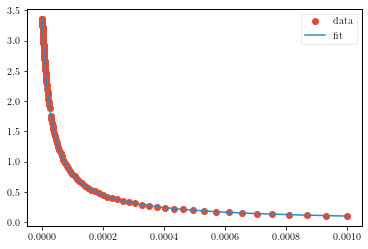

In [24]:
from scipy.optimize import curve_fit

def curve(x, L, b):
    y = L / (1 + x*b)
    return (y)

xdata = u1_values
ydata = r0_values[:, 10]

p0 = [max(ydata), np.median(xdata)] # this is an mandatory initial guess

popt, pcov = curve_fit(curve, xdata, ydata, p0, method='dogbox')

x = np.linspace(xdata[0], xdata[-1], 1000)
y = curve(x, popt[0], popt[1])

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')

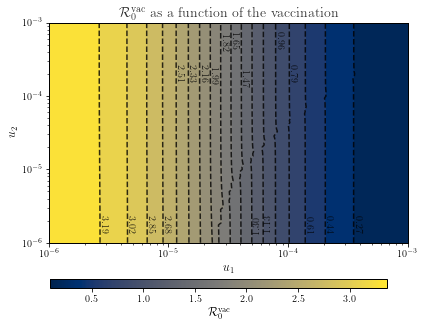

In [25]:
# Plotting
fig, ax = plt.subplots(1,1, figsize=(6,4))

vmin = r0_values.min()
vmax = r0_values.max()

# Define the contour levels
levels = np.linspace(vmin, vmax, 20)

ax.contourf(u1_values, u2_values, r0_values[:,:].T, cmap='cividis', levels=levels)
contour = ax.contour(u1_values, u2_values, r0_values[:,:].T, colors='black', alpha=0.8,
                          levels=levels, linestyles='--')

clabels = ax.clabel(contour, inline=False, fontsize=10, fmt='%1.2f')
for label in clabels:
    x, y = label.get_position()  # get current position
    label.set_position((x, y))  # set new position
    label.set_va("center")
    label.set_ha("left")
ax.set_title(r'$\mathcal{R}_0^{\mathrm{vac}}$ as a function of the vaccination', color='black', alpha=0.8, fontsize=14)

ax.set_xlabel(r'$u_1$', fontsize=12)
ax.set_ylabel(r'$u_2$', fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()

cbar_ax = fig.add_axes([0.125, -0.013, 0.78, 0.03])
fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='cividis'), 
             cax=cbar_ax, orientation='horizontal', label=r'$\mathcal{R}_0^{\mathrm{vac}}$')

#plt.savefig('../images/r0_function_vaccination.pdf', bbox_inches='tight')
plt.show()

## K cities

We move to more general formulations.

In [26]:
# number of cities
K = 5

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5
beta = np.array([0.4, 0.3, 0.15, 0.15, 0.1])
alpha = 0.64

# Population settings
x1 = 0.2
population = 1e5*np.array([50, 10, 10, 1, 1])
p_matrix = np.array([[1,0,0,0,0],[x1,1-x1,0,0,0],[x1,0,1-x1,0,0],[x1,0,0,1-x1,0],[x1,0,0,0,1-x1]])
population_eff = population @ p_matrix

# Vaccination
vaccination_strategies = np.array([
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [1e-3, 1e-3, 1e-3, 1e-3, 1e-3],
    [1e-2, 1e-2, 1e-2, 1e-2, 1e-2],
    [1e-1, 1e-1, 1e-1, 1e-1, 1e-1],
])

# Initial condition
y0 = np.zeros(5*K)
y0[K] = 1/population[0]
y0[0:K] = 1-y0[K:2*K]

n_days = 180
t_eval = np.linspace(0, n_days, 100 * n_days)
sol = [0,0,0,0]

Doing the calculations

In [27]:
args = (vaccination_strategies[0], alpha, beta, tau, gamma, K, p_matrix, population, population_eff)

sol[0] = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                   t_span=(0,n_days),
                   y0=y0,
                   method='RK45',
                   t_eval=t_eval,
                   max_step=1e-2
                  )

In [28]:
s = 90

for k in range(1,4):
    args = (vaccination_strategies[k], alpha, beta, tau, gamma, K, p_matrix, population, population_eff)
    sol[k] = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                       t_span=(s,n_days),
                       y0=sol[0].y[:,s*100],
                       method='RK45',
                       t_eval=t_eval[s*100:],
                       max_step=1e-2
                      )

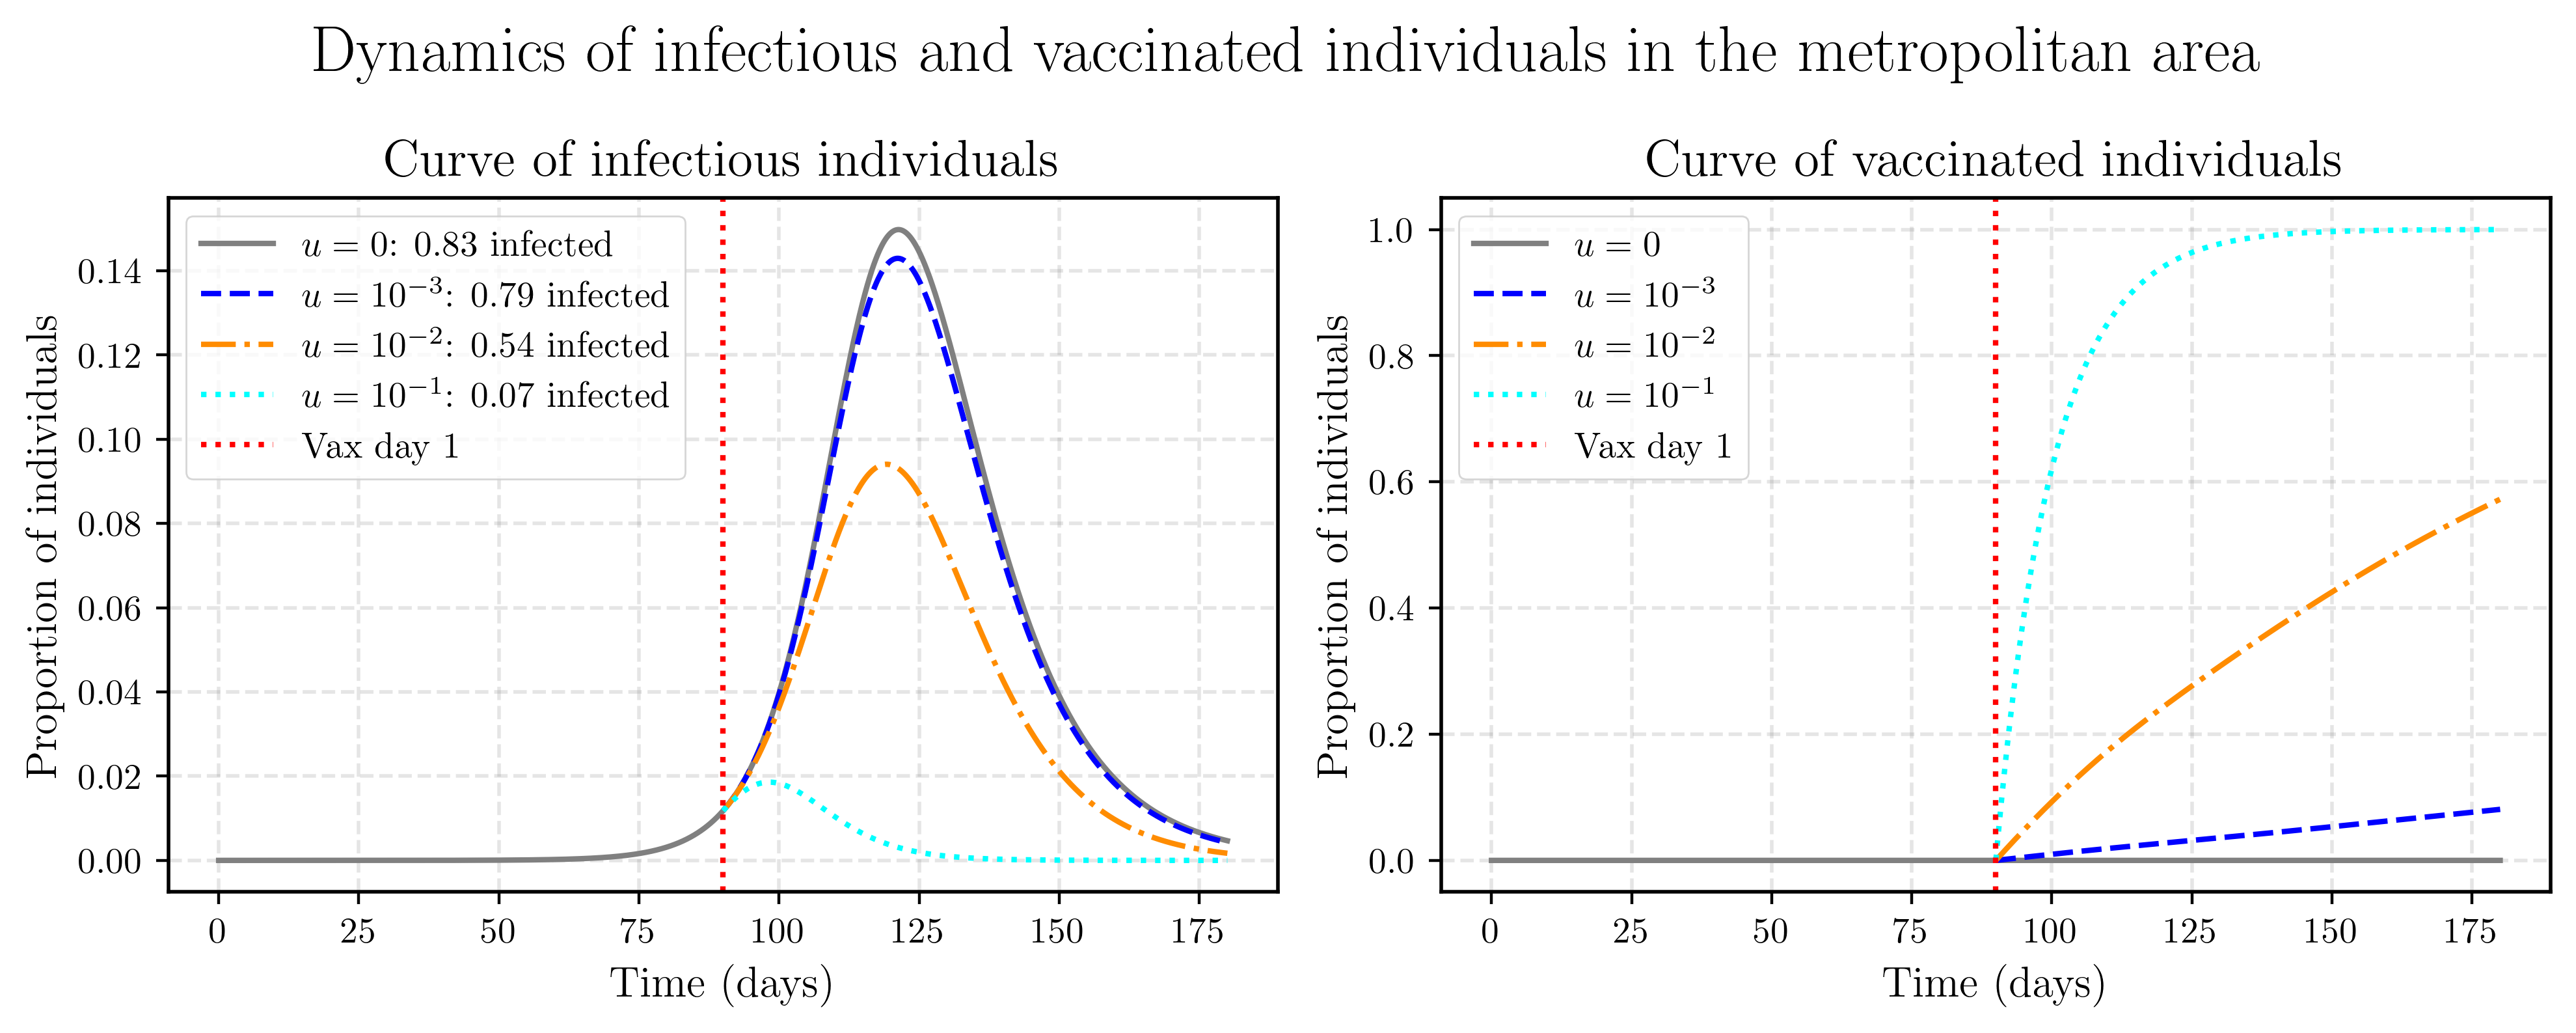

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

colors = ['gray', 'blue', 'darkorange','cyan']
linestyles = ['-', '--', '-.', ':']

labels = [r'$u = 0$', r'$u = 10^{-3}$', r'$u = 10^{-2}$', r'$u = 10^{-1}$']

# Plotting infected
for k in range(4):
    ax[0].plot(sol[k].t, (sol[k].y[2*K:3*K] * population[:, np.newaxis]).sum(axis=0)/population.sum(),
               label=labels[k] + ': {:.2f} infected'.format(((sol[k].y[4*K:]*population[:, np.newaxis]).sum(axis=0)/population.sum())[-1]), 
               c=colors[k], ls=linestyles[k])
    
ax[0].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
ax[0].axvline(90, c='red', ls=':', label='Vax day 1')

ax[0].set_title('Curve of infectious individuals')
ax[0].set_ylabel('Proportion of individuals')
ax[0].set_xlabel('Time (days)')
ax[0].legend()

# Plotting vaccinated
for k in range(4):
    index = np.arange(sol[k].y[:4*K].shape[0]) % 5
    ax[1].plot(sol[k].t, 1 - (sol[k].y[:4*K] * population.reshape(-1,1)[index]).sum(axis=0)/population.sum(),
               label=labels[k], c=colors[k], ls=linestyles[k])
    
ax[1].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
ax[1].axvline(90, c='red', ls=':', label='Vax day 1')

ax[1].set_title('Curve of vaccinated individuals')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Proportion of individuals')
ax[1].legend()
    
fig.suptitle('Dynamics of infectious and vaccinated individuals in the metropolitan area', fontsize=18)

plt.tight_layout()
plt.savefig('../images/epidemic_behaviour_vaccination.pdf', bbox_inches='tight')
plt.show()

In [52]:
s = [None, 50, 90, 120]

for k in range(1,4):
    args = (vaccination_strategies[2], alpha, beta, tau, gamma, K, p_matrix, population, population_eff)
    sol[k] = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                       t_span=(s[k],n_days),
                       y0=sol[0].y[:,s[k]*100],
                       method='RK45',
                       t_eval=t_eval[s[k]*100:],
                       max_step=1e-2
                      )

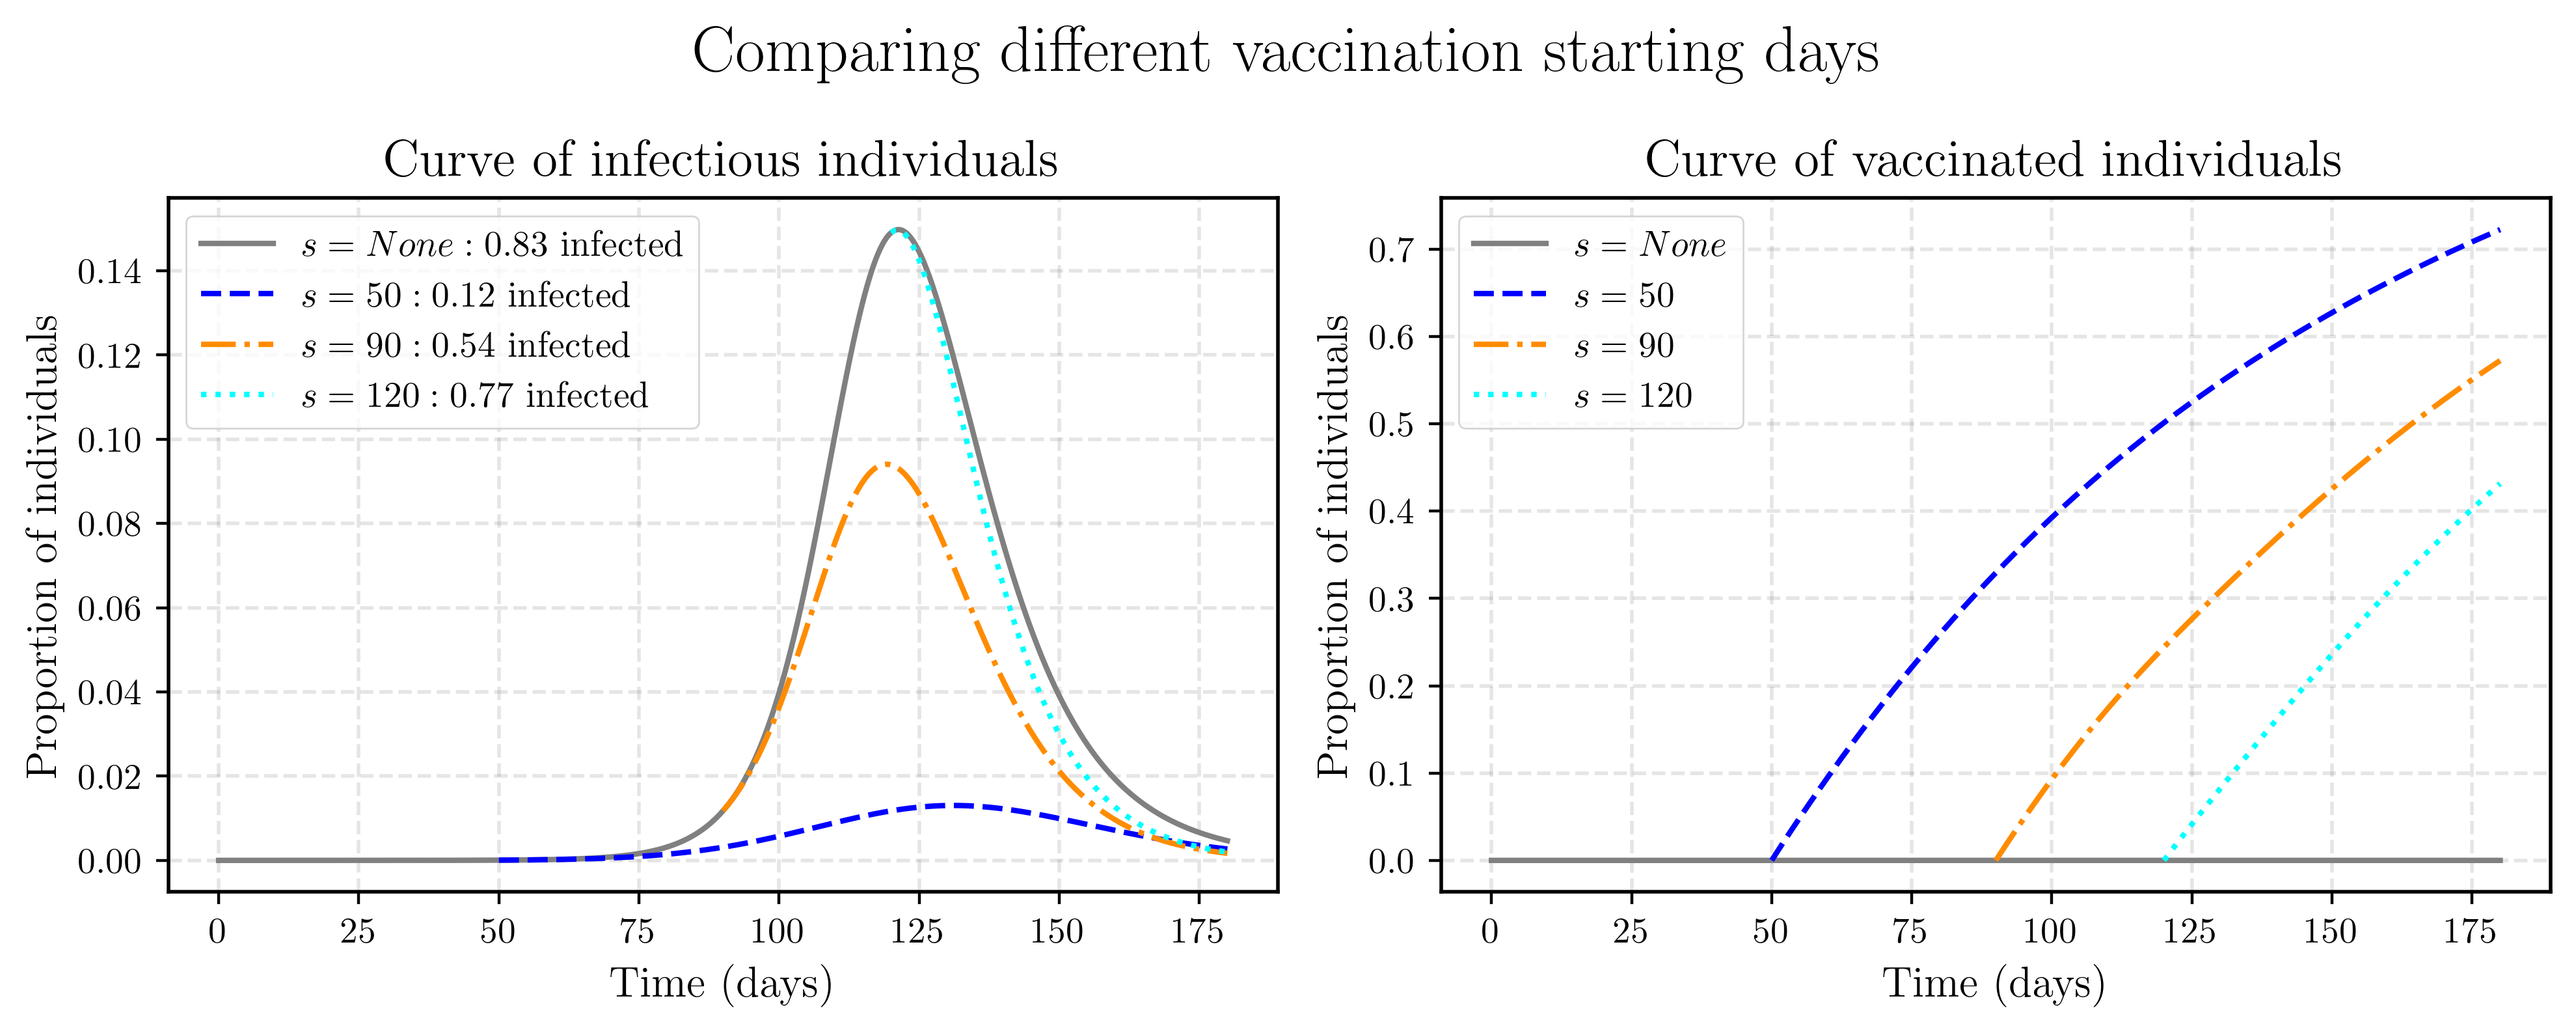

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

colors = ['gray', 'blue', 'darkorange','cyan']
linestyles = ['-', '--', '-.', ':']

# Plotting infected
for k in range(4):
    ax[0].plot(sol[k].t, (sol[k].y[2*K:3*K] * population[:, np.newaxis]).sum(axis=0)/population.sum(),
               label=r'$s = {}: {:.2f}$ infected'.format(s[k],
                   ((sol[k].y[4*K:]*population[:, np.newaxis]).sum(axis=0)/population.sum())[-1],                                            ), 
               c=colors[k], ls=linestyles[k])
    
ax[0].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
#ax[0].axvline(90, c='red', ls=':', label='Vax day 1')

ax[0].set_title('Curve of infectious individuals')
ax[0].set_ylabel('Proportion of individuals')
ax[0].set_xlabel('Time (days)')
ax[0].legend()

# Plotting vaccinated
for k in range(4):
    index = np.arange(sol[k].y[:4*K].shape[0]) % 5
    ax[1].plot(sol[k].t, 1 - (sol[k].y[:4*K] * population.reshape(-1,1)[index]).sum(axis=0)/population.sum(),
               label=r'$s = {}$'.format(s[k]), c=colors[k], ls=linestyles[k])
    
ax[1].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
#ax[1].axvline(90, c='red', ls=':', label='Vax day 1')

ax[1].set_title('Curve of vaccinated individuals')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Proportion of individuals')
ax[1].legend()
    
fig.suptitle('Comparing different vaccination starting days', fontsize=18)

plt.tight_layout()
plt.savefig('../images/epidemic_behaviour_vaccination_different_days.pdf', bbox_inches='tight')
plt.show()

In [16]:
import gekko as gk

Now, let's see how we optimize the choice of the constant rates.

In [47]:
def optimal_vaccination_strategy(parameters):
    # Gekko object
    m = gk.GEKKO(remote=True)

    # Including the time
    T = parameters['T']
    npd = 20
    n_points = npd*T + 1
    m.time = np.linspace(0, T, n_points)

    # Number of cities
    populations = parameters['populations']/parameters['populations'].sum()
    K = len(populations)

    p = parameters['p_matrix']
    population_eff = populations @ p_matrix

    # parameters
    beta = parameters['beta']
    cv = m.Const(parameters['cv'])
    ch = m.Const(parameters['ch'])
    rh = m.Const(parameters['rh'])
    alpha = m.Const(parameters['alpha'])
    tau = m.Const(parameters['tau'])
    gamma = m.Const(parameters['gamma'])

    # Initial values
    e0 = parameters['e0']
    i0 = parameters['i0']
    r0 = parameters['r0']
    s0 = np.ones(K) - e0 - i0 - r0    

    # Including the variables
    s = m.Array(m.Var, K, lb=0.0)
    e = m.Array(m.Var, K, lb=0.0)
    i = m.Array(m.Var, K, lb=0.0)
    r = m.Array(m.Var, K, lb=0.0)
    v = m.Array(m.Var, K, lb=0.0, value=0.0)
    h = m.Array(m.Var, K, lb=0.0, value=0.0)

    u = [m.FV(lb=0.0, ub=0.7, value=7*(0.1 - 0.02*city/(K-1))) for city in range(K)]
    for city in range(K):
        s[city].value = s0[city]
        e[city].value = e0[city]
        i[city].value = i0[city]
        r[city].value = r0[city]
        u[city].STATUS = 1

    # Maximizing 
    obj_points = np.zeros(n_points)
    obj_points[-1] = 1.0
    final = m.Param(value=obj_points)
    m.Obj(cv * m.sum(v*populations) * final + ch * m.sum(h*populations) * final)

    # ODE equations
    i_eff = [m.Intermediate(m.sum(p_matrix[:,city]*populations*i)/population_eff[city]) for city in range(K)]
    for city in range(K):
        new_infections = s[city] * (alpha*beta[city]*i[city] + (1-alpha)*m.sum(beta*p_matrix[city,:]*i_eff))
        m.Equation(s[city].dt() == -new_infections - s[city]*u[city])
        m.Equation(e[city].dt() == new_infections - (tau+u[city])*e[city])
        m.Equation(i[city].dt() == tau*e[city] - gamma*i[city])
        m.Equation(r[city].dt() == gamma*i[city] - u[city]*r[city])
        m.Equation(v[city].dt() == u[city]*(s[city] + e[city] + r[city]))
        m.Equation(h[city].dt() == rh*i[city])

    # Constraints
    m.Equation(m.sum(v*populations) * final  <= 0.8)

    # Solving
    m.options.IMODE = 5
    m.options.NODES = 2
    m.options.SOLVER = 3  # Using IPOPT solver
    m.options.MAX_ITER = 500  # Increasing maximum iterations

    m.solve(disp=True)
    
    return m, s, e, i, r, v, h, u

We move to setting the parameters.

In [48]:
# number of cities
K = 5

# Fixed parameters
tau = 7 * 1/3
gamma = 7 * 1/7
alpha = 0.64

# Population settings
x1 = 0.2
populations = 1e5*np.array([50, 10, 10, 1, 1])
p_matrix = np.array([[1,0,0,0,0],[x1,1-x1,0,0,0],[x1,0,1-x1,0,0],[x1,0,0,1-x1,0],[x1,0,0,0,1-x1]])
population_eff = populations @ p_matrix

# Initial condition
y0 = np.zeros(4*K)
y0[K] = 1/population[0]
y0[0:K] = 1-y0[K:2*K]

# Days
n_days = 180
t_eval = np.linspace(0, n_days, 100 * n_days)

# Variable settings
y0_vac = None
beta = 7 * np.array([0.4, 0.3, 0.15, 0.15, 0.1])
cv = 0.001

parameters = {'T': 12, 'populations': populations, 'p_matrix': p_matrix,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': y0_vac, 
              'i0': y0_vac, 
              'r0': y0_vac,
              'cv': cv, 'ch': 1000, 'rh': 0.1}

In [49]:
beta_values = [
    7*np.array([0.2, 0.2, 0.2, 0.2, 0.2]),
    7*np.array([0.4, 0.3, 0.15, 0.15, 0.1]),
    7*np.array([0.5, 0.15, 0.15, 0.1, 0.05])
]

cv_values = [0.001, 0.1, 10]

sol_control = [[0,0,0],[0,0,0],[0,0,0]]

In [50]:
for i, beta in enumerate(beta_values):
    for j, cv in enumerate(cv_values):
        parameters['beta'] = beta
        parameters['cv'] = cv
        
        args = (np.zeros(K), alpha, beta/7, tau/7, gamma/7, K, p_matrix, populations, population_eff)
        sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                        t_span=(0,n_days),
                        y0=y0,
                        method='RK45',
                        t_eval=t_eval,
                        max_step=1e-2
                        )
        parameters['e0'] =  sol.y[K:2*K, 90*100]
        parameters['i0'] =  sol.y[2*K:3*K, 90*100]
        parameters['r0'] =  sol.y[3*K:, 90*100]
        
        _, _, _, _, _, _, _, u = optimal_vaccination_strategy(parameters)
        sol_control[i][j] = u

apm 189.60.59.111_gk_model38 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            6
   Variables    :           37
   Intermediates:            5
   Connections  :            0
   Equations    :           37
   Residuals    :           32
 
 Number of state variables:          14645
 Number of total equations: -        14640
 Number of slack variables: -          240
 ---------------------------------------
 Degrees of freedom       :           -235
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
T

   1  6.4225933e+00 1.61e-01 9.33e+02  -0.4 7.90e-01    -  2.48e-02 9.87e-01h  1
   2  2.6704046e+00 2.65e-02 7.65e+02  -0.5 2.03e-01   2.0 1.00e+00 9.90e-01h  1
   3  4.0752841e-01 3.83e-04 6.39e+02  -1.3 6.30e-02   1.5 1.00e+00 9.82e-01h  1
   4  5.4806298e-02 1.25e-04 1.49e+03  -7.5 2.73e-02    -  9.40e-01 1.00e+00h  1
   5  3.3441188e-02 4.84e-05 2.18e+03  -3.2 2.05e-01    -  8.22e-01 1.00e+00H  1
   6  3.3333114e-02 5.14e-07 4.08e+02  -5.2 2.01e-03    -  9.87e-01 1.00e+00h  1
   7  3.1452478e-02 1.26e-04 3.70e-01  -5.5 3.11e-02    -  1.00e+00 1.00e+00h  1
   8  2.5615381e-02 2.13e-03 4.31e-01  -6.0 1.31e-01    -  1.00e+00 1.00e+00h  1
   9  2.2304185e-02 1.88e-03 1.66e-01  -5.8 1.32e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2202317e-02 2.98e-05 4.06e-02  -6.3 1.30e-02    -  1.00e+00 1.00e+00h  1
  11  2.1105013e-02 1.13e-04 2.16e-02  -7.0 3.55e-02    -  1.00e+00 1.00e+00h  1
  12  2.0429682e-02 2.10e-04

 Number of state variables:          14645
 Number of total equations: -        14640
 Number of slack variables: -          240
 ---------------------------------------
 Degrees of freedom       :           -235
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    60210
Number of nonzeros in inequality constraint Jacobian.:        0
Number of non

  72  5.4883434e+00 2.38e-03 3.09e+05  -5.6 2.04e-01    -  2.41e-01 9.42e-02h  1
  73  5.4585962e+00 2.21e-03 2.77e+05  -5.1 2.05e-01    -  4.89e-02 1.03e-01h  1
  74  5.4576469e+00 2.20e-03 2.76e+05 -11.0 2.07e-01    -  1.72e-02 3.06e-03h  1
  75  5.4343901e+00 2.07e-03 2.53e+05  -5.2 2.07e-01    -  3.58e-01 8.28e-02h  1
  76  5.4077001e+00 1.94e-03 2.30e+05  -5.8 2.07e-01    -  5.07e-02 9.07e-02h  1
  77  5.4073380e+00 1.94e-03 2.30e+05 -11.0 2.11e-01    -  4.22e-03 1.23e-03h  1
  78  5.3821466e+00 1.83e-03 2.09e+05  -5.5 2.09e-01    -  1.58e-01 9.13e-02h  1
  79  5.3580320e+00 1.72e-03 1.90e+05  -5.5 2.10e-01    -  4.87e-02 9.00e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  5.3577476e+00 1.72e-03 3.25e+05 -11.0 2.15e-01    -  5.80e-03 1.02e-03h  1
  81  5.3341180e+00 1.63e-03 1.73e+05  -5.6 2.12e-01    -  1.75e-01 9.02e-02h  1
  82  5.3281592e+00 1.59e-03 3.00e+05  -5.6 2.13e-01    -  4.81e-02 2.32e-02h  1
  83  5.3117309e+00 1.52e-03

 165  4.5348877e+00 1.47e-03 3.44e+05  -5.0 4.76e-01    -  1.51e-01 7.94e-02h  1
 166  4.5252117e+00 1.49e-03 5.01e+05  -4.6 4.80e-01    -  4.30e-02 8.74e-02h  1
 167  4.5243850e+00 1.49e-03 4.99e+05 -10.8 5.02e-01    -  1.10e-02 3.61e-03h  1
 168  4.5290919e+00 1.50e-03 4.59e+05  -4.2 4.90e-01    -  6.70e-02 7.85e-02h  1
 169  4.5158277e+00 1.52e-03 5.27e+05  -4.9 4.98e-01    -  1.05e-02 7.55e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  4.5156854e+00 1.51e-03 5.77e+05 -10.8 5.03e-01    -  2.16e-03 6.11e-04h  1
 171  4.5028696e+00 1.54e-03 5.09e+05  -4.8 5.01e-01    -  8.99e-02 8.27e-02f  1
 172  4.9942394e+00 4.53e-03 3.01e+06  -3.4 8.15e-01    -  1.96e-02 2.78e-01f  1
 173  4.5332160e+00 7.24e-03 1.24e+06  -4.6 3.91e-01    -  2.54e-01 5.84e-01h  1
 174  4.4340587e+00 7.22e-03 5.76e+05  -4.6 5.05e-01    -  2.41e-02 5.29e-01h  1
 175  4.4338505e+00 7.21e-03 5.75e+05 -10.6 5.55e-01    -  1.65e-01 8.41e-04h  1
 176  4.4191368e+00 6.79e-03

   2  5.7444031e+01 5.12e-01 2.97e+03   0.3 2.06e+00    -  3.47e-02 1.71e-01f  1
   3  6.0362700e+01 4.39e-01 2.56e+03  -0.3 1.52e+00    -  2.01e-01 1.46e-01f  1
   4  1.1266568e+02 3.93e-01 5.21e+03   0.9 3.61e+00    -  9.85e-01 9.02e-02f  1
   5  1.1221736e+02 3.53e-01 3.86e+04   1.5 5.44e-01    -  9.88e-01 1.04e-01f  1
   6  9.6901586e+01 1.65e-01 5.36e+04   1.9 3.85e-01    -  1.00e+00 6.32e-01h  1
   7  7.5029628e+01 4.37e-02 2.81e+05   1.8 2.05e-01    -  1.05e-01 7.93e-01h  1
   8  7.2081123e+01 3.64e-03 3.01e+04   0.5 1.40e-01    -  7.83e-01 9.97e-01h  1
   9  7.2041929e+01 2.92e-05 8.88e+01   0.0 1.12e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.2002894e+01 1.21e-07 1.38e+03  -2.1 1.07e-03    -  9.89e-01 1.00e+00h  1
  11  7.0148108e+01 2.83e-04 3.96e-01  -2.4 5.18e-02    -  1.00e+00 1.00e+00f  1
  12  5.2324847e+01 2.93e-02 9.11e+00  -2.5 5.10e-01    -  9.54e-01 1.00e+00f  1
  13  4.7520855e+01 9.96e-04

  95  5.3782830e+00 1.08e-03 5.01e+05 -11.0 2.30e-01    -  3.25e-03 1.01e-03h  1
  96  5.3588972e+00 1.05e-03 4.64e+05  -5.2 2.25e-01    -  1.40e-01 7.47e-02h  1
  97  5.3418204e+00 1.02e-03 4.26e+05  -4.8 2.28e-01    -  3.89e-02 8.06e-02h  1
  98  5.3410020e+00 1.02e-03 4.25e+05 -11.0 2.33e-01    -  9.87e-03 2.89e-03h  1
  99  5.3372547e+00 9.88e-04 3.93e+05  -4.3 2.31e-01    -  5.81e-02 7.39e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.3540172e+00 1.03e-03 4.37e+05  -4.1 2.30e-01    -  4.07e-02 1.52e-01h  1
 101  5.3516749e+00 1.02e-03 4.59e+05 -10.8 2.44e-01    -  3.12e-02 7.00e-03h  1
 102  5.3454964e+00 9.95e-04 4.47e+05  -4.3 2.41e-01    -  6.94e-02 6.09e-02h  1
 103  5.3323476e+00 9.73e-04 4.15e+05  -4.4 2.42e-01    -  5.23e-02 8.10e-02h  1
 104  5.3345114e+00 1.00e-03 3.66e+05  -4.1 2.42e-01    -  6.13e-02 1.33e-01h  1
 105  5.3312907e+00 9.94e-04 3.64e+05 -10.6 2.55e-01    -  2.06e-02 8.94e-03h  1
 106  5.3147926e+00 9.68e-04

 188  4.3506608e+00 8.43e-03 4.55e+02  -4.9 3.39e-01    -  1.00e+00 1.00e+00h  1
 189  4.3330861e+00 8.33e-03 9.90e+03  -5.0 1.04e+00    -  1.00e+00 1.03e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  4.3290854e+00 8.02e-03 3.06e+04  -5.0 5.90e-01    -  1.53e-02 4.16e-02h  1
 191  4.3115261e+00 7.28e-03 5.90e+04  -5.0 5.78e-01    -  4.26e-02 1.88e-01f  1
 192  4.2970113e+00 6.67e-03 4.08e+04  -5.0 5.92e-01    -  6.99e-02 1.62e-01f  1
 193  4.2837769e+00 6.18e-03 3.66e+04  -5.0 6.03e-01    -  9.28e-02 1.53e-01f  1
 194  4.2705548e+00 5.77e-03 3.09e+04  -5.0 6.13e-01    -  1.47e-01 1.58e-01f  1
 195  4.2579349e+00 5.43e-03 2.61e+04  -5.0 6.25e-01    -  1.36e-01 1.55e-01h  1
 196  4.2450644e+00 5.16e-03 3.84e+04  -5.0 6.36e-01    -  3.95e-02 1.63e-01h  1
 197  4.2307034e+00 5.02e-03 1.69e+05  -5.0 6.45e-01    -  2.83e-02 1.88e-01f  1
 198  4.2157699e+00 5.00e-03 1.40e+05  -5.0 6.61e-01    -  4.63e-02 2.01e-01f  1
 199  4.2038181e+00 4.88e-03

  18  2.5225263e+01 3.80e-03 7.97e+02  -3.9 2.12e-01    -  8.88e-01 5.08e-01h  1
  19  2.4991689e+01 3.59e-03 5.23e+03  -9.8 1.50e-01    -  3.92e-01 5.96e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.4921013e+01 3.53e-03 4.91e+03 -10.0 1.34e-01    -  2.11e-02 1.86e-02h  1
  21  2.4575037e+01 3.25e-03 1.19e+04  -4.8 1.24e-01    -  5.56e-02 9.28e-02h  1
  22  2.4129223e+01 2.93e-03 9.68e+03  -4.4 1.04e-01    -  5.84e-02 1.28e-01h  1
  23  2.3628495e+01 2.63e-03 7.70e+03  -4.2 8.62e-02    -  9.82e-02 1.55e-01h  1
  24  2.3534766e+01 2.56e-03 1.04e+04 -10.1 1.16e-01    -  7.92e-02 2.91e-02h  1
  25  2.3151581e+01 2.33e-03 7.40e+03  -5.5 1.14e-01    -  1.36e-01 1.21e-01h  1
  26  2.2633181e+01 2.10e-03 1.33e+04  -4.6 9.70e-02    -  8.34e-02 1.78e-01h  1
  27  2.2574018e+01 2.06e-03 2.83e+04 -10.2 1.17e-01    -  6.30e-02 2.11e-02h  1
  28  2.2287782e+01 1.91e-03 3.37e+04  -5.2 1.08e-01    -  6.81e-01 1.03e-01h  1
  29  2.1778625e+01 1.75e-03

 111  1.2996011e+01 1.20e-03 2.75e+05  -5.0 2.81e-01    -  2.18e-01 7.27e-02h  1
 112  1.2978293e+01 1.17e-03 2.55e+05  -5.4 2.84e-01    -  4.07e-02 7.46e-02h  1
 113  1.2978032e+01 1.17e-03 2.89e+05 -11.0 2.96e-01    -  3.21e-03 1.02e-03h  1
 114  1.2961652e+01 1.14e-03 2.36e+05  -5.2 2.87e-01    -  1.48e-01 7.47e-02h  1
 115  1.2947992e+01 1.12e-03 2.21e+05  -5.3 2.91e-01    -  4.03e-02 6.07e-02h  1
 116  1.2944330e+01 1.10e-03 3.60e+05  -7.1 3.03e-01    -  6.06e-02 1.48e-02h  1
 117  1.2927855e+01 1.08e-03 2.08e+05  -5.3 2.94e-01    -  1.39e-01 7.54e-02h  1
 118  1.2911864e+01 1.07e-03 1.87e+05  -5.3 2.98e-01    -  4.00e-02 7.46e-02h  1
 119  1.2911629e+01 1.07e-03 3.49e+05 -11.0 3.12e-01    -  3.39e-03 9.90e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.2896889e+01 1.05e-03 1.73e+05  -5.1 3.02e-01    -  1.95e-01 7.42e-02h  1
 121  1.2883489e+01 1.03e-03 1.69e+05  -5.3 3.06e-01    -  4.00e-02 6.59e-02h  1
 122  1.2881364e+01 1.03e-03

 204  1.2082955e+01 3.86e-03 3.48e+05  -5.2 8.42e-01    -  3.30e-01 1.40e-01h  1
 205  1.2077302e+01 3.76e-03 3.25e+05  -5.0 8.63e-01    -  8.09e-02 6.42e-02h  1
 206  1.2073473e+01 3.71e-03 2.99e+05  -4.7 9.07e-01    -  8.68e-01 8.34e-02h  1
 207  1.2066032e+01 3.93e-03 2.55e+05  -4.7 8.79e-01    -  8.42e-02 1.46e-01h  1
 208  1.2064950e+01 3.90e-03 2.53e+05 -10.7 9.26e-01    -  8.46e-03 7.77e-03h  1
 209  1.2083958e+01 4.14e-03 2.14e+05  -4.2 8.97e-01    -  9.73e-02 1.51e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.2079756e+01 4.02e-03 2.03e+05  -4.7 9.26e-01    -  2.44e-02 5.10e-02h  1
 211  1.2066365e+01 9.06e-05 1.39e+08  -4.7 4.16e-02    -  5.69e-04 1.00e+00f  1
 212  1.2300686e+01 9.79e-04 1.07e+04  -4.1 1.06e-01    -  1.00e+00 1.00e+00f  1
 213  1.2239831e+01 1.10e-03 1.18e+03  -4.2 1.57e-01    -  2.38e-01 1.00e+00h  1
 214  1.2225731e+01 1.05e-03 2.31e+04  -4.2 2.53e+00    -  2.04e-01 6.08e-03H  1
Reallocating memory for MA57

   1  1.1820175e+02 1.62e-01 1.15e+03  -0.5 7.90e-01    -  2.00e-02 1.00e+00f  1
   2  6.5884549e+01 7.12e-02 3.39e+02  -0.8 2.54e-01    -  6.32e-01 6.27e-01h  1
   3  6.3019887e+01 4.78e-02 2.67e+02  -0.9 3.75e-01    -  5.30e-01 3.45e-01h  1
   4  6.0135935e+01 2.19e-02 3.17e+03  -1.3 3.13e-01    -  1.00e+00 5.73e-01h  1
   5  5.9761129e+01 1.96e-02 3.10e+03  -2.8 2.13e-01    -  5.11e-01 1.02e-01h  1
   6  5.9756208e+01 1.96e-02 3.16e+04  -7.5 1.22e-01    -  2.90e-01 1.81e-03h  1
   7  6.1527347e+01 1.22e-02 4.68e+04  -1.1 4.98e-01    -  1.00e+00 5.37e-01h  1
   8  6.1502825e+01 1.18e-02 3.10e+06  -1.6 9.90e-02    -  1.00e+00 3.10e-02h  1
   9  6.1703534e+01 1.09e-02 2.57e+07  -1.3 5.24e-01    -  1.00e+00 7.83e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.1854221e+01 1.02e-02 3.64e+08  -0.7 9.75e-01    -  1.00e+00 7.01e-02h  1
  11  6.1887349e+01 9.98e-03 2.02e+10   0.5 4.39e+00    -  1.00e+00 1.73e-02h  1
Reallocating memory for MA57

  88  3.6246440e+01 2.77e-03 7.91e+05  -4.5 1.63e-01  -3.4 5.84e-02 2.04e-01h  1
  89  3.6241530e+01 2.76e-03 9.08e+05 -11.0 1.64e-01  -3.0 3.51e-02 4.36e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.6111688e+01 2.50e-03 5.52e+05  -4.5 1.63e-01  -3.4 6.14e-02 1.21e-01h  1
  91  3.5992752e+01 2.29e-03 4.93e+05  -4.8 1.63e-01  -3.0 6.89e-02 1.10e-01h  1
  92  3.5988012e+01 2.29e-03 6.95e+05 -11.0 1.64e-01  -3.5 4.02e-02 4.28e-03h  1
  93  3.5915281e+01 2.15e-03 4.65e+05  -4.8 1.63e-01  -3.1 6.60e-01 6.82e-02h  1
  94  3.5805634e+01 1.98e-03 7.38e+05  -4.2 1.67e-01  -3.5 5.60e-02 1.11e-01h  1
  95  3.5777891e+01 2.78e-03 8.82e+05  -3.3 1.97e+00  -4.0 4.29e-02 8.16e-02f  2
  96  3.5470897e+01 2.18e-03 6.10e+05  -4.1 2.13e-01    -  2.31e-01 2.85e-01h  1
  97  3.5443465e+01 2.12e-03 5.71e+05 -10.3 1.69e-01    -  8.51e-02 2.62e-02h  1
  98  3.5429897e+01 2.10e-03 5.61e+05 -10.4 1.70e-01    -  2.39e-02 1.30e-02h  1
  99  3.5341791e+01 1.93e-03

 181  3.1713656e+01 6.25e-04 1.53e+06 -10.1 3.61e-01    -  2.06e-03 8.18e-04h  1
 182  3.1661623e+01 6.29e-04 1.44e+06  -4.3 3.49e-01    -  1.30e-01 4.98e-02h  1
 183  3.1604709e+01 6.39e-04 2.33e+06  -3.8 3.52e-01    -  2.64e-02 5.57e-02h  1
 184  3.1599411e+01 6.36e-04 2.41e+06 -10.1 3.63e-01    -  6.78e-03 4.96e-03h  1
 185  3.1551268e+01 6.41e-04 1.91e+06  -3.3 3.59e-01    -  3.90e-02 4.99e-02f  1
 186  3.1501526e+01 6.45e-04 1.83e+06  -3.6 3.64e-01    -  3.58e-02 4.86e-02h  1
 187  3.1495300e+01 6.42e-04 1.82e+06 -10.0 3.73e-01    -  9.21e-03 5.83e-03h  1
 188  3.1456023e+01 6.39e-04 1.78e+06  -4.2 3.74e-01    -  1.27e-01 3.70e-02h  1
 189  3.1401833e+01 6.48e-04 2.64e+06  -4.0 3.72e-01    -  2.97e-02 5.21e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  3.1351179e+01 6.53e-04 2.53e+06  -4.4 3.78e-01    -  2.88e-02 4.82e-02h  1
 191  3.1350242e+01 6.52e-04 2.53e+06 -10.0 3.96e-01    -  2.26e-03 8.57e-04h  1
 192  3.1298918e+01 6.59e-04

 274  2.7075957e+01 4.64e-03 5.71e+05  -4.0 7.58e-01    -  1.05e-01 1.63e-01h  1
 275  2.7069368e+01 4.58e-03 5.63e+05 -10.2 8.00e-01    -  4.37e-02 1.29e-02h  1
 276  2.7014246e+01 4.41e-03 5.00e+05  -4.2 7.97e-01    -  5.65e-01 1.11e-01h  1
 277  2.7033714e+01 4.28e-03 6.08e+05  -2.4 3.05e+00    -  1.99e-02 3.39e-02f  3
 278  2.6868741e+01 5.83e-03 3.27e+05  -3.9 7.68e-01    -  1.37e-01 3.47e-01h  1
 279  2.6843558e+01 5.62e-03 3.03e+05  -9.9 8.90e-01    -  1.10e-01 5.12e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  2.6843284e+01 5.62e-03 3.03e+05  -9.9 9.24e-01    -  8.08e-04 5.42e-04h  1
 281  2.6768887e+01 5.46e-03 1.61e+06  -5.0 8.52e-01    -  4.31e-02 1.59e-01h  1
 282  2.6760750e+01 5.38e-03 2.06e+06  -5.0 8.82e-01    -  9.33e-02 1.75e-02h  1
 283  2.6690867e+01 5.26e-03 1.91e+06  -4.1 8.80e-01    -  7.27e-01 1.52e-01h  1
 284  2.6660364e+01 5.05e-03 1.59e+06  -4.9 9.03e-01    -  9.71e-02 6.62e-02h  1
 285  2.6615019e+01 4.87e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.1907772e+01 9.84e-03 7.46e+15   2.2 4.04e-06  17.5 9.90e-01 1.00e+00f  1
  21  6.1907788e+01 9.84e-03 6.64e+17  -2.9 1.21e+01    -  1.31e-02 8.85e-05h  1
  22  6.1907731e+01 9.84e-03 6.08e+17   1.3 2.90e-01    -  1.83e-06 3.68e-05h  1
  23r 6.1907731e+01 9.84e-03 1.00e+03   2.2 0.00e+00    -  0.00e+00 3.00e-07R  5
  24r 7.6380139e+01 1.88e-02 1.74e+01   1.2 1.65e-01    -  9.83e-01 1.00e+00f  1
  25r 7.7083166e+01 3.26e-03 5.58e+00  -4.9 6.58e-02    -  8.50e-01 9.20e-01f  1
  26  6.2198926e+01 2.12e-03 1.61e+01  -6.7 6.74e-02    -  7.13e-01 8.37e-01f  1
  27  6.0700009e+01 5.78e-05 1.07e+00  -3.3 2.90e-02    -  8.75e-01 1.00e+00h  1
  28  6.0664166e+01 7.40e-06 4.07e-01  -4.1 8.96e-03    -  8.75e-01 1.00e+00h  1
  29  5.9520657e+01 4.36e-03 2.84e+00  -8.9 2.15e-01    -  2.08e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.6432170e+01 3.45e-02

 111  3.3232379e+01 1.45e-03 6.76e+05  -4.1 2.35e-01    -  4.70e-02 6.21e-02h  1
 112  3.3222755e+01 1.44e-03 6.70e+05 -10.3 2.39e-01    -  1.86e-02 9.79e-03h  1
 113  3.3186110e+01 1.40e-03 6.35e+05  -4.3 2.39e-01    -  1.10e-01 3.79e-02h  1
 114  3.3124175e+01 1.34e-03 9.73e+05  -4.3 2.38e-01    -  3.85e-02 6.48e-02h  1
 115  3.3057668e+01 1.28e-03 6.98e+05  -4.0 2.40e-01    -  3.55e-02 7.11e-02h  1
 116  3.3050971e+01 1.28e-03 7.36e+05 -10.3 2.45e-01    -  1.53e-02 6.86e-03h  1
 117  3.3006825e+01 1.23e-03 5.54e+05  -3.9 2.45e-01    -  7.48e-02 4.75e-02f  1
 118  3.2937719e+01 1.19e-03 6.09e+05  -3.8 2.45e-01    -  4.11e-02 7.66e-02h  1
 119  3.2882668e+01 1.15e-03 5.94e+05  -3.9 2.49e-01    -  5.12e-02 5.97e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.2864272e+01 1.13e-03 5.83e+05 -10.2 2.53e-01    -  1.82e-02 1.90e-02h  1
 121  3.2838492e+01 1.10e-03 7.91e+05  -5.2 2.56e-01    -  8.24e-02 2.65e-02h  1
 122  3.2778779e+01 1.07e-03

 204  2.9092538e+01 1.53e-03 2.07e+06 -10.0 6.01e-01    -  2.19e-02 1.03e-02h  1
 205  2.9055691e+01 1.52e-03 1.99e+06  -3.5 5.99e-01    -  7.27e-02 4.49e-02f  1
 206  2.8996899e+01 1.54e-03 1.85e+06  -3.6 5.87e-01    -  4.77e-02 7.35e-02h  1
 207  2.8901666e+01 1.72e-03 1.59e+06  -3.2 5.77e-01    -  4.78e-02 1.28e-01h  1
 208  2.8898162e+01 1.71e-03 1.58e+06  -9.9 6.37e-01    -  9.04e-03 4.18e-03h  1
 209  2.8841892e+01 1.72e-03 1.47e+06  -3.9 6.07e-01    -  8.46e-02 7.12e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  2.8790507e+01 1.72e-03 1.38e+06  -4.8 6.20e-01    -  4.50e-02 6.44e-02h  1
 211  2.8789901e+01 1.71e-03 1.37e+06  -9.9 6.78e-01    -  2.35e-03 7.08e-04h  1
 212  2.8733307e+01 1.73e-03 1.27e+06  -4.7 6.21e-01    -  1.30e-01 7.22e-02h  1
 213  2.8604407e+01 2.22e-03 7.01e+06  -3.2 5.84e-01    -  3.20e-02 1.91e-01h  1
 214  2.8594627e+01 2.20e-03 6.93e+06  -9.9 6.95e-01    -  6.98e-02 1.19e-02h  1
 215  2.8586629e+01 2.18e-03

  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    60210
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9600

Reallocating memory for MA57: lfact (2769994)
Reallocating memory for MA57: lfact (2991058)
Total number of variables............................:    14645
                     variables with only lower bounds:     7440
                variables with lower and upper bounds:        5
                     variables with only up

  71  5.4134252e+01 3.55e-03 1.91e+06  -7.2 1.98e-01    -  2.96e-02 1.70e-02h  1
  72  5.4123857e+01 3.48e-03 1.87e+06  -5.9 1.82e-01    -  2.16e-02 2.00e-02h  1
  73  5.4101802e+01 3.34e-03 1.79e+06  -5.7 1.75e-01    -  8.61e-02 4.29e-02h  1
  74  5.4074801e+01 3.61e-03 1.66e+06  -4.4 6.12e-01    -  1.35e-02 7.59e-02h  1
  75  5.4070118e+01 3.58e-03 1.64e+06 -11.0 1.75e-01    -  1.65e-02 9.07e-03h  1
  76  5.4051124e+01 3.43e-03 1.57e+06  -4.8 1.48e-01    -  7.55e-02 4.17e-02h  1
  77  5.4021877e+01 3.39e-03 1.45e+06  -4.4 4.28e-01    -  4.62e-02 7.63e-02h  1
  78  5.3993047e+01 6.19e-03 1.28e+06  -4.1 1.04e+00    -  3.04e-02 1.23e-01h  1
  79  5.3986676e+01 6.12e-03 1.26e+06 -10.9 1.61e-01    -  2.74e-02 1.24e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  5.3972971e+01 5.95e-03 1.23e+06  -5.6 1.59e-01    -  8.34e-02 2.71e-02h  1
  81  5.3942420e+01 5.59e-03 1.15e+06  -5.4 1.58e-01    -  4.89e-02 6.17e-02h  1
  82  5.3912673e+01 5.25e-03

 164  5.2283680e+01 3.43e-03 9.93e+05  -5.3 2.30e-01    -  1.23e-02 5.53e-02f  1
 165  5.2283316e+01 3.42e-03 9.90e+05 -11.0 2.34e-01    -  6.69e-03 2.34e-03h  1
 166  5.2281224e+01 3.37e-03 9.76e+05  -5.6 2.33e-01    -  4.36e-02 1.43e-02h  1
 167  5.2274205e+01 3.16e-03 9.15e+05  -4.9 2.32e-01    -  4.53e-02 6.30e-02h  1
 168  5.2271804e+01 3.11e-03 9.00e+05  -6.9 2.36e-01    -  1.79e-02 1.57e-02h  1
 169  5.2266652e+01 2.99e-03 8.66e+05  -5.3 2.37e-01    -  6.37e-02 3.84e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  5.2261547e+01 2.89e-03 7.35e+05  -4.5 2.31e-01    -  1.34e-02 1.52e-01h  1
 171  5.2260351e+01 2.87e-03 7.29e+05 -11.0 2.50e-01    -  4.27e-02 7.60e-03h  1
 172  5.2255880e+01 2.76e-03 7.02e+05  -5.0 2.46e-01    -  5.76e-02 3.74e-02h  1
 173  5.2249737e+01 2.65e-03 6.74e+05  -6.3 2.46e-01    -  4.18e-02 4.02e-02h  1
 174  5.2246678e+01 2.60e-03 6.61e+05  -6.8 2.52e-01    -  5.76e-02 1.98e-02h  1
 175  5.2243956e+01 2.52e-03

 257  5.1993596e+01 1.66e-02 7.59e+05 -11.0 4.79e-01    -  4.66e-03 4.14e-03h  1
 258  5.1989809e+01 1.62e-02 7.38e+05  -6.4 4.76e-01    -  3.40e-02 2.72e-02h  1
 259  5.1985822e+01 1.57e-02 7.16e+05  -5.6 4.79e-01    -  1.35e-01 2.97e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  5.1983720e+01 1.53e-02 6.98e+05  -4.6 4.72e-01    -  5.30e-03 2.62e-02h  1
 261  5.1981880e+01 1.51e-02 6.88e+05  -5.6 4.95e-01    -  6.50e-02 1.39e-02h  1
 262  5.1977765e+01 1.46e-02 6.67e+05 -11.0 4.85e-01    -  1.69e-02 2.97e-02h  1
 263  5.1976536e+01 1.45e-02 6.61e+05  -6.3 4.99e-01    -  6.90e-03 9.10e-03h  1
 264  5.1968618e+01 1.36e-02 6.20e+05  -5.5 4.72e-01    -  7.49e-02 6.28e-02h  1
 265  5.1968248e+01 1.36e-02 6.18e+05 -11.0 4.89e-01    -  2.81e-03 2.79e-03h  1
 266  5.1964644e+01 1.32e-02 6.01e+05  -6.1 4.83e-01    -  4.19e-02 2.78e-02h  1
 267  5.1959938e+01 1.27e-02 5.76e+05  -5.2 4.89e-01    -  7.87e-02 4.12e-02h  1
 268  5.1959052e+01 1.22e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  5.1423306e+01 1.38e-03 4.82e+03  -7.6 2.38e-01    -  1.42e-01 3.14e-02h  1
 351  5.1422898e+01 1.32e-03 3.91e+03  -7.2 2.36e-01    -  3.16e-01 9.24e-02h  1
 352  5.1422757e+01 1.28e-03 4.87e+03  -6.0 2.38e-01    -  8.41e-02 1.08e-01h  1
 353  5.1422628e+01 1.23e-03 3.05e+03  -6.0 2.41e-01    -  6.71e-02 1.01e-01h  1
 354  5.1422489e+01 1.19e-03 3.40e+03  -6.0 2.44e-01    -  7.49e-02 9.53e-02h  1
 355  5.1422321e+01 1.16e-03 3.15e+03  -6.0 2.48e-01    -  9.16e-02 8.09e-02h  1
 356  5.1422022e+01 1.12e-03 2.90e+03  -6.4 2.51e-01    -  1.01e-01 7.18e-02h  1
 357  5.1421948e+01 1.12e-03 3.19e+03  -5.8 2.50e-01    -  6.99e-02 1.32e-01h  1
 358  5.1421741e+01 1.09e-03 3.09e+03  -7.3 2.61e-01    -  1.02e-01 3.72e-02h  1
 359  5.1421276e+01 1.07e-03 2.80e+03  -7.1 2.58e-01    -  1.31e-01 8.72e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  5.1420820e+01 1.05e-03

 442  5.1400123e+01 6.31e-03 3.58e+03  -6.4 7.74e-01    -  5.69e-02 2.01e-01f  1
 443  5.1399254e+01 7.20e-03 1.85e+03  -6.4 7.77e-01    -  1.14e-01 3.24e-01f  1
 444  5.1399204e+01 7.11e-03 1.83e+03 -11.0 8.47e-01    -  2.45e-02 1.38e-02h  1
 445  5.1398765e+01 6.99e-03 1.44e+03  -6.3 8.33e-01    -  1.41e-01 2.15e-01f  1
 446  5.1398723e+01 6.91e-03 1.41e+03 -11.0 9.03e-01    -  8.81e-02 1.21e-02h  1
 447  5.1398675e+01 6.77e-03 1.36e+03  -6.4 8.91e-01    -  2.35e-01 2.36e-02h  1
 448  5.1437325e+01 8.24e-03 1.57e+05  -4.9 3.09e-01    -  9.27e-03 1.00e+00h  1
 449  5.1416295e+01 1.79e-04 1.58e+02  -6.0 6.10e-02  -1.8 7.91e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  5.1415134e+01 7.27e-06 4.81e-02  -6.0 7.68e-03  -2.3 1.00e+00 1.00e+00h  1
 451  5.1412284e+01 2.45e-04 1.05e+00  -7.1 7.35e-02  -2.8 1.00e+00 1.00e+00h  1
 452  5.1408090e+01 1.71e-03 1.22e-01  -7.1 2.09e-01  -3.2 1.00e+00 9.31e-01h  1
 453  5.1398979e+01 3.56e-03

In [51]:
sol_control_c = np.array([[np.array(l2)[:,0]/7 for l2 in l1] for l1 in sol_control])

In [56]:
for i in range(3):
    for j in range(3):
        values = tuple(sol_control_c[i,j])
        print("beta_{} | c_{} | {} | {} | {} | {} | {}".format(i,j,*values))

beta_0 | c_0 | 0.044364385578571426 | 0.006258391661857142 | 0.006258391314857142 | 0.004842721756285714 | 0.004842721903000001
beta_0 | c_1 | 8.442594069142857e-09 | 2.826220004857143e-08 | 2.8262170681428573e-08 | 2.880739500714286e-07 | 2.88035593e-07
beta_0 | c_2 | 1.5529570597142857e-12 | 2.2076856840000002e-09 | 2.2067375794285714e-09 | 2.853481549e-08 | 2.8527176865714286e-08
beta_1 | c_0 | 1.0 | 0.017396211391428572 | 0.0 | 0.0 | 0.0
beta_1 | c_1 | 1.0 | 0.01739621134142857 | 0.0 | 0.0 | 0.0
beta_1 | c_2 | 1.0 | 0.017396206844285715 | 0.0 | 5.479851783e-09 | 4.6309604017142855e-09
beta_2 | c_0 | 1.0 | 0.005861746603428571 | 0.005861746603428571 | 5.109801800285714e-10 | 5.291276464428571e-10
beta_2 | c_1 | 1.0 | 0.005861741348142858 | 0.005861741348142858 | 4.461173389857143e-08 | 2.0420165861428573e-08
beta_2 | c_2 | 0.0 | 1.0 | 1.0 | 0.9999999970714286 | 6.1192533112857145e-09


In [102]:
beta_values = [
    7*np.array([0.3, 0.3, 0.3, 0.3, 0.3]),
    7*np.array([0.4, 0.3, 0.15, 0.15, 0.1]),
    7*np.array([0.5, 0.15, 0.15, 0.1, 0.05])
]

cv_values = [0.001, 0.1, 10]

for i, beta in enumerate(beta_values):
    for j, cv in enumerate(cv_values):
        parameters['beta'] = beta
        parameters['cv'] = cv
        
        args = (np.zeros(K), alpha, beta/7, tau/7, gamma/7, K, p_matrix, populations, population_eff)
        sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                        t_span=(0, n_days),
                        y0=y0,
                        method='RK45',
                        t_eval=t_eval,
                        max_step=1e-2
                        )
        index = np.where((sol.y[2*K:3*K,:]*populations.reshape(-1,1)).sum(axis=0)/populations.sum() >= 0.03)[0][0]
        parameters['e0'] =  sol.y[K:2*K, index]
        parameters['i0'] =  sol.y[2*K:3*K, index]
        parameters['r0'] =  sol.y[3*K:, index]
        
        _, _, _, _, _, _, _, u = optimal_vaccination_strategy(parameters)
        sol_control[i][j] = u

apm 189.60.59.111_gk_model48 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            6
   Variables    :           37
   Intermediates:            5
   Connections  :            0
   Equations    :           37
   Residuals    :           32
 
 Number of state variables:          14645
 Number of total equations: -        14640
 Number of slack variables: -          240
 ---------------------------------------
 Degrees of freedom       :           -235
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
T

  67  2.0852898e+01 1.03e-03 2.60e+05  -4.6 2.31e-01  -1.8 1.16e-01 7.95e-02h  1
  68  2.0818581e+01 1.12e-03 3.85e+05  -4.1 2.30e-01  -2.3 4.48e-02 1.87e-01h  1
  69  2.0816720e+01 1.11e-03 3.80e+05 -10.9 2.43e-01  -1.9 4.72e-02 9.83e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.0806323e+01 1.07e-03 3.62e+05  -4.5 2.41e-01  -2.4 9.41e-02 5.37e-02h  1
  71  2.0787881e+01 1.05e-03 3.25e+05  -4.4 2.41e-01  -1.9 6.26e-02 1.00e-01h  1
  72  2.0761481e+01 1.07e-03 2.77e+05  -4.2 2.43e-01  -2.4 7.28e-02 1.42e-01h  1
  73  2.0760562e+01 1.07e-03 2.75e+05 -10.7 2.54e-01  -2.0 1.22e-02 4.91e-03h  1
  74  2.0744137e+01 1.04e-03 2.53e+05  -4.7 2.51e-01  -2.5 6.74e-02 8.19e-02h  1
  75  2.0726952e+01 1.02e-03 2.22e+05  -3.8 2.37e-01  -2.1 3.70e-02 1.07e-01h  3
  76  2.0668224e+01 1.53e-03 1.54e+05  -4.4 2.50e-01  -2.5 2.73e-01 3.06e-01h  1
  77  2.0663628e+01 1.50e-03 1.49e+05 -10.5 2.81e-01  -2.1 1.25e-01 2.37e-02h  1
  78  2.0661505e+01 1.49e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.9965948e+01 8.53e-03 2.31e+06  -3.2 1.12e+00    -  2.04e-02 1.74e-01f  2
 161  1.9881129e+01 6.21e-03 1.52e+06  -4.5 5.79e-01    -  2.05e-01 3.41e-01h  1
 162  1.9746291e+01 7.47e-03 7.22e+05  -4.5 5.47e-01    -  4.00e-02 5.21e-01h  1
 163  1.9586390e+01 2.43e-03 3.27e+05  -4.5 9.94e-02    -  6.74e-03 1.00e+00f  1
 164  1.9490674e+01 9.50e-03 3.63e+03  -4.9 3.98e-01  -1.5 1.00e+00 9.93e-01h  1
 165  1.9472601e+01 9.13e-03 1.14e+04  -5.0 9.70e-01    -  9.71e-01 5.56e-02h  1
 166  1.9441859e+01 8.75e-03 2.77e+04  -4.7 6.72e-01    -  1.05e-01 3.26e-01h  1
 167  1.9436904e+01 8.51e-03 2.68e+04 -10.9 7.37e-01    -  1.15e-01 3.11e-02h  1
 168  1.9427263e+01 8.08e-03 3.92e+04  -5.5 7.39e-01    -  4.13e-01 6.40e-02h  1
 169  1.9400589e+01 7.49e-03 4.80e+04  -5.4 7.20e-01    -  1.38e-01 1.83e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.9375330e+01 7.02e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.2616608e+01 1.12e-02 4.17e+01  -4.7 1.80e-01  -2.1 1.00e+00 1.00e+00h  1
  21  2.2113911e+01 1.08e-02 1.17e+02  -5.1 1.94e-01  -2.5 1.00e+00 1.00e+00h  1
  22  2.1717306e+01 1.05e-02 2.50e+02  -5.2 2.06e-01  -2.1 1.00e+00 1.00e+00h  1
  23  2.1695430e+01 9.86e-03 6.59e+03  -5.2 2.27e-01  -2.6 1.00e+00 6.57e-02h  1
  24  2.1676514e+01 9.32e-03 9.07e+03 -11.0 2.21e-01  -2.2 1.03e-01 5.92e-02h  1
  25  2.1585497e+01 7.46e-03 7.87e+04  -4.9 2.19e-01  -2.6 5.05e-02 2.89e-01h  1
  26  2.1571029e+01 7.11e-03 7.48e+04 -11.0 2.15e-01  -2.2 8.64e-02 4.94e-02h  1
  27  2.1570870e+01 7.11e-03 7.48e+04 -11.0 5.58e-01  -2.7 9.77e-04 6.78e-04h  1
  28  2.1536164e+01 6.39e-03 6.58e+04  -6.7 2.14e-01  -2.3 1.81e-01 1.20e-01h  1
  29  2.1308949e+01 7.10e-03 8.24e+05  -4.2 2.09e-01  -1.8 2.79e-02 8.26e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1301876e+01 6.91e-03

 112  1.9914127e+01 4.23e-03 3.33e+05 -10.5 5.57e-01    -  3.34e-02 1.28e-02h  1
 113  1.9899119e+01 3.98e-03 3.12e+05  -4.6 5.58e-01    -  1.71e-01 6.22e-02f  1
 114  1.9874730e+01 3.57e-03 2.78e+05  -4.6 5.47e-01    -  6.86e-02 1.09e-01h  1
 115  1.9854720e+01 3.33e-03 2.58e+05  -5.8 5.66e-01    -  7.00e-02 7.06e-02h  1
 116  1.9849911e+01 3.27e-03 2.53e+05 -10.6 6.04e-01    -  6.02e-02 1.68e-02h  1
 117  1.9822398e+01 2.97e-03 2.27e+05  -5.5 5.67e-01    -  2.39e-01 1.02e-01h  1
 118  1.9821902e+01 2.96e-03 2.26e+05 -10.7 6.06e-01    -  2.76e-03 1.79e-03h  1
 119  1.9797768e+01 2.69e-03 2.03e+05  -4.9 5.76e-01    -  1.05e-01 1.03e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.9787450e+01 2.59e-03 1.95e+05  -5.3 5.87e-01    -  5.84e-02 4.10e-02h  1
 121  1.9772220e+01 2.44e-03 2.39e+05  -5.1 6.07e-01    -  4.58e-01 6.34e-02h  1
 122  1.9749920e+01 2.27e-03 4.08e+05  -4.8 5.94e-01    -  6.26e-02 1.07e-01h  1
 123  1.9752971e+01 2.41e-03

   1  2.3279325e+01 7.24e-01 1.52e+02   0.2 1.22e+00    -  1.00e+00 8.30e-02f  1
   2  3.9259312e+01 6.62e-01 2.53e+04   1.8 1.80e+00    -  2.82e-01 8.67e-02f  1
   3  1.6441264e+02 1.63e-01 1.25e+05   2.1 6.62e-01    -  6.30e-01 1.00e+00f  1
   4  7.8949652e+01 3.92e-02 7.66e+05   2.2 2.50e-01    -  3.52e-01 9.80e-01h  1
   5  6.6534287e+01 2.08e-03 9.25e+03   1.5 6.71e-02    -  9.56e-01 1.00e+00h  1
   6  6.6812234e+01 1.03e-04 3.81e+03   1.0 2.89e-02    -  9.78e-01 1.00e+00f  1
   7  6.6794178e+01 2.66e-08 5.58e+00  -0.9 3.16e-04    -  1.00e+00 1.00e+00h  1
   8  6.6636686e+01 3.60e-06 2.66e+01  -3.0 5.63e-03    -  9.71e-01 1.00e+00f  1
   9  5.7656353e+01 1.30e-02 1.10e-01  -2.6 3.37e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0676976e+01 1.33e-02 7.09e+00  -2.9 3.29e-01    -  9.99e-01 5.71e-01h  1
  11  4.3911098e+01 7.02e-03 1.82e+00  -3.0 1.43e-01    -  1.00e+00 1.00e+00h  1
  12  4.0735939e+01 5.02e-03

  94  2.8370889e+01 8.46e-03 1.02e+07 -10.7 3.11e-01    -  1.10e-02 9.60e-04h  1
  95  2.8347416e+01 7.85e-03 9.40e+06  -5.1 3.01e-01    -  2.96e-01 7.56e-02h  1
  96  2.8324495e+01 7.27e-03 8.67e+06  -4.9 3.05e-01    -  4.11e-02 7.78e-02h  1
  97  2.8324125e+01 7.26e-03 8.66e+06 -10.8 3.18e-01    -  9.88e-03 1.12e-03h  1
  98  2.8302958e+01 6.74e-03 8.01e+06  -4.8 3.09e-01    -  1.72e-01 7.48e-02h  1
  99  2.8345149e+01 6.08e-03 6.07e+06  -3.8 3.59e-01    -  3.05e-02 2.44e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8342731e+01 6.03e-03 6.03e+06 -10.7 3.42e-01    -  1.21e-01 6.97e-03h  1
 101  2.8331419e+01 5.82e-03 5.81e+06  -4.7 3.31e-01    -  1.30e-01 3.66e-02h  1
 102  2.8309037e+01 5.39e-03 5.33e+06  -4.4 3.25e-01    -  8.60e-02 8.29e-02h  1
 103  2.8286037e+01 5.03e-03 4.96e+06  -5.5 3.32e-01    -  4.84e-02 6.98e-02h  1
 104  2.8285694e+01 5.02e-03 4.95e+06 -10.7 3.46e-01    -  3.03e-03 1.01e-03h  1
 105  2.8261391e+01 4.66e-03

 187  2.7523205e+01 3.89e-03 4.15e+05  -4.7 7.81e-01    -  1.74e-02 1.46e-01h  1
 188  2.7521669e+01 3.87e-03 4.41e+05 -10.7 8.17e-01    -  2.97e-02 6.24e-03h  1
 189  2.7504467e+01 3.87e-03 3.68e+05  -4.4 8.11e-01    -  1.97e-01 1.20e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  2.7499035e+01 4.95e-03 2.73e+05  -4.1 7.78e-01    -  9.22e-02 2.67e-01h  1
 191  2.7496249e+01 4.90e-03 2.69e+05 -10.5 8.94e-01    -  4.45e-02 1.11e-02h  1
 192  2.7473638e+01 4.86e-03 2.32e+05  -4.6 8.47e-01    -  1.22e-01 1.38e-01h  1
 193  2.7470693e+01 4.81e-03 2.29e+05 -10.6 8.83e-01    -  2.66e-02 1.22e-02h  1
 194  2.7457622e+01 4.85e-03 1.95e+05  -4.3 8.61e-01    -  1.33e-01 1.49e-01h  1
 195  2.7436145e+01 4.71e-03 1.76e+05  -5.9 9.02e-01    -  1.18e-01 9.13e-02h  1
 196  2.7430010e+01 4.61e-03 1.71e+05  -6.7 9.74e-01    -  1.49e-01 2.62e-02h  1
 197  2.7397154e+01 4.72e-03 1.43e+05  -5.6 8.96e-01    -  3.84e-01 1.52e-01h  1
 198  2.7414901e+01 4.63e-03

  29  1.2840654e+01 6.42e-03 4.88e+04 -10.7 1.97e-01    -  3.71e-02 2.15e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.2759174e+01 5.80e-03 4.34e+04  -6.2 1.96e-01    -  1.70e-01 1.11e-01h  1
  31  1.2682030e+01 5.26e-03 3.87e+04  -6.4 1.94e-01    -  5.86e-02 1.09e-01h  1
  32  1.2680944e+01 5.26e-03 5.70e+04 -10.9 1.93e-01    -  3.59e-03 1.59e-03h  1
  33  1.2607481e+01 4.78e-03 4.47e+04  -5.9 1.93e-01    -  1.16e-01 1.09e-01h  1
  34  1.2573728e+01 4.55e-03 5.26e+04  -6.1 1.91e-01    -  5.76e-02 5.14e-02h  1
  35  1.2535926e+01 4.31e-03 9.06e+04  -5.7 1.91e-01    -  2.67e-01 5.89e-02h  1
  36  1.2468322e+01 3.93e-03 4.43e+04  -5.9 1.90e-01    -  1.66e-01 1.07e-01h  1
  37  1.2400953e+01 3.58e-03 1.43e+05  -5.2 1.89e-01    -  5.63e-02 1.14e-01h  1
  38  1.2345398e+01 3.31e-03 1.31e+05  -5.8 1.89e-01    -  6.51e-02 9.30e-02h  1
  39  1.2344773e+01 3.31e-03 1.95e+05 -11.0 1.89e-01    -  4.18e-03 1.06e-03h  1
iter    objective    inf_pr 

 121  1.0402164e+01 9.24e-04 3.40e+06  -5.0 3.61e-01    -  3.88e-02 4.98e-02h  1
 122  1.0390624e+01 9.12e-04 3.33e+06  -5.6 3.79e-01    -  8.83e-02 2.07e-02h  1
 123  1.0354668e+01 9.24e-04 3.09e+06  -5.0 3.65e-01    -  2.10e-01 7.09e-02h  1
 124  1.0549614e+01 1.07e-03 2.66e+06  -3.3 5.84e-01    -  3.48e-02 1.36e-01f  1
 125  1.0547473e+01 1.06e-03 2.65e+06  -4.4 3.96e-01    -  5.91e-03 3.35e-03h  1
 126  1.0502544e+01 1.07e-03 2.46e+06  -4.4 3.80e-01    -  4.58e-02 7.21e-02f  1
 127  1.0455201e+01 1.08e-03 2.27e+06  -4.4 3.83e-01    -  3.95e-02 7.93e-02f  1
 128  1.0413105e+01 1.09e-03 2.10e+06  -4.4 3.91e-01    -  1.20e-02 7.34e-02f  1
 129  1.0366297e+01 1.12e-03 2.16e+06  -4.4 3.94e-01    -  1.30e-02 8.51e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.0321857e+01 1.14e-03 1.76e+06  -4.4 4.01e-01    -  2.23e-02 8.41e-02f  1
 131  1.0318996e+01 1.14e-03 1.75e+06 -10.3 4.27e-01    -  4.48e-02 4.30e-03h  1
 132  1.0306070e+01 1.12e-03

 214  8.7535239e+00 1.33e-02 2.66e+06  -4.9 8.56e-01    -  3.69e-01 2.00e-01h  1
 215  8.7529555e+00 1.33e-02 2.65e+06  -5.0 4.85e-01    -  4.07e-03 3.53e-03h  1
 216  9.4099348e+00 8.31e-03 1.64e+06  -3.4 5.98e-01    -  2.02e-02 3.77e-01f  1
 217  9.3723143e+00 6.54e-05 6.94e+04  -4.4 1.23e-02  -0.7 3.98e-01 1.00e+00h  1
 218  9.2986698e+00 7.54e-05 5.07e+04 -10.3 2.43e-01    -  4.51e-01 8.92e-02h  1
 219  8.7631476e+00 5.11e-03 1.51e+04  -5.1 3.05e-01    -  1.00e+00 7.03e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  8.6300291e+00 5.60e-04 6.32e+02  -5.1 8.30e-02    -  1.00e+00 9.58e-01h  1
 221  8.6101933e+00 4.51e-05 4.59e+02 -11.0 1.45e-02    -  2.69e-01 9.20e-01h  1
 222  8.6081290e+00 2.77e-06 7.41e+00 -11.0 2.17e-03    -  9.79e-01 9.39e-01h  1
 223  8.6079258e+00 4.72e-09 9.50e-08  -8.9 2.47e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 223

                                   (scaled)                 (unscaled)
Object

  41  1.2276674e+01 2.89e-03 2.64e+05  -5.7 1.89e-01    -  5.70e-02 7.97e-02h  1
  42  1.2265628e+01 2.83e-03 2.66e+05  -7.3 1.89e-01    -  8.94e-02 1.96e-02h  1
  43  1.2210384e+01 2.62e-03 2.38e+05  -5.6 1.89e-01    -  3.00e-01 1.01e-01h  1
  44  1.2157368e+01 2.43e-03 2.18e+05  -5.6 1.89e-01    -  5.22e-02 9.90e-02h  1
  45  1.2156645e+01 2.42e-03 2.57e+05 -11.0 1.90e-01    -  4.77e-03 1.34e-03h  1
  46  1.2106615e+01 2.25e-03 1.94e+05  -5.4 1.89e-01    -  2.22e-01 9.74e-02h  1
  47  1.2057615e+01 2.09e-03 3.25e+05  -5.1 1.89e-01    -  5.06e-02 1.01e-01h  1
  48  1.2056423e+01 2.09e-03 3.77e+05 -11.0 1.90e-01    -  1.05e-02 2.30e-03h  1
  49  1.2021476e+01 1.95e-03 4.98e+05  -4.5 1.90e-01    -  6.75e-02 9.88e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.1980001e+01 1.87e-03 1.19e+06  -4.1 1.89e-01    -  4.40e-02 2.45e-01h  1
  51  1.1974032e+01 1.85e-03 1.30e+06 -11.0 1.96e-01    -  1.06e-01 1.03e-02h  1
  52  1.1973311e+01 1.85e-03

 134  1.0094858e+01 3.54e-03 1.44e+06  -4.9 4.65e-01    -  4.79e-01 4.07e-02h  1
 135  1.0045466e+01 3.22e-03 1.31e+06  -4.7 4.53e-01    -  5.12e-02 8.91e-02h  1
 136  9.9968544e+00 2.95e-03 1.20e+06  -5.0 4.60e-01    -  4.98e-02 8.46e-02h  1
 137  9.9962862e+00 2.95e-03 1.20e+06 -10.5 4.91e-01    -  4.38e-03 9.47e-04h  1
 138  9.9481512e+00 2.80e-03 1.09e+06  -5.0 4.64e-01    -  1.66e-01 8.85e-02h  1
 139  9.9651547e+00 2.91e-03 1.77e+06  -3.8 4.52e-01    -  4.05e-02 1.92e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  9.9609436e+00 2.89e-03 1.76e+06 -10.5 5.01e-01    -  4.72e-02 6.79e-03h  1
 141  9.9480859e+00 2.79e-03 1.62e+06  -3.9 4.82e-01    -  8.60e-02 8.14e-02h  1
 142  9.9054298e+00 2.69e-03 1.49e+06  -4.7 4.89e-01    -  6.70e-02 7.94e-02h  1
 143  9.9036810e+00 2.68e-03 1.48e+06 -10.4 5.00e-01    -  7.86e-03 2.98e-03h  1
 144  9.8604325e+00 2.60e-03 1.35e+06  -4.6 4.91e-01    -  2.41e-01 8.84e-02h  1
 145  9.8129084e+00 2.53e-03

   1  8.7561528e+01 7.30e-01 1.45e+03  -0.8 2.47e+00    -  1.29e-02 3.89e-01f  1
   2  1.3339641e+02 6.44e-01 1.19e+03   0.2 1.75e+00    -  9.54e-01 1.20e-01f  1
   3  1.4088611e+02 4.90e-01 6.56e+03   1.3 8.84e-01    -  8.47e-01 2.52e-01f  1
   4  1.2850228e+02 2.26e-01 2.25e+04  -4.8 3.64e-01    -  1.49e-02 6.19e-01h  1
   5  8.2150451e+01 6.64e-02 7.44e+03   0.2 2.21e-01    -  4.78e-01 8.46e-01h  1
   6  7.6302280e+01 7.63e-03 2.48e+03   0.1 1.98e-01    -  3.75e-01 8.92e-01h  1
   7  7.6093563e+01 8.09e-05 2.06e+02  -0.5 3.63e-02    -  9.66e-01 1.00e+00h  1
   8  7.6018023e+01 2.79e-06 3.88e+02  -2.0 5.34e-03    -  9.56e-01 1.00e+00h  1
   9  7.5928770e+01 1.63e-06 5.63e+01  -7.5 4.10e-03    -  9.37e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7894678e+01 2.44e-02 4.60e+01  -4.2 5.00e-01    -  1.40e-01 1.00e+00f  1
  11  5.6732867e+01 4.59e-02 3.20e+01  -3.0 1.60e+00  -2.0 9.97e-01 2.35e-01f  1
  12  4.7533389e+01 9.41e-03

  94  1.9427141e+01 9.59e-04 5.24e+06  -3.7 2.44e-01    -  2.99e-02 2.25e-01h  1
  95  1.9408158e+01 9.39e-04 5.09e+06  -4.6 2.49e-01    -  9.34e-02 2.86e-02h  1
  96  1.9356725e+01 9.22e-04 7.82e+07  -4.6 2.43e-01    -  5.58e-04 8.00e-02f  1
  97  1.9293176e+01 9.23e-04 7.01e+07  -4.6 2.46e-01    -  8.89e-03 1.03e-01f  1
  98  1.9291505e+01 9.20e-04 6.99e+07 -10.5 2.58e-01    -  4.73e-02 2.37e-03h  1
  99  1.9278888e+01 9.07e-04 6.86e+07  -5.1 2.59e-01    -  2.14e-01 1.88e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9234746e+01 8.90e-04 6.39e+07  -4.9 2.53e-01    -  7.01e-02 6.87e-02h  1
 101  1.9210412e+01 8.70e-04 6.15e+07  -5.1 2.57e-01    -  3.67e-02 3.78e-02h  1
 102  1.9191050e+01 8.53e-04 5.96e+07  -5.1 2.63e-01    -  1.64e-01 3.03e-02h  1
 103  1.9149712e+01 8.41e-04 5.55e+07  -4.9 2.60e-01    -  4.46e-02 6.87e-02h  1
 104  1.9110462e+01 8.29e-04 5.19e+07  -4.9 2.63e-01    -  3.68e-02 6.59e-02h  1
 105  1.9109935e+01 8.29e-04

 187  1.7546021e+01 1.96e-03 1.15e+06 -10.3 6.19e-01    -  3.04e-03 1.16e-03h  1
 188  1.7502236e+01 1.99e-03 1.04e+06  -5.0 5.80e-01    -  2.45e-01 9.52e-02h  1
 189  1.7480261e+01 2.11e-03 9.14e+05  -4.1 5.78e-01    -  5.03e-02 1.23e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.7475922e+01 2.09e-03 9.06e+05 -10.4 6.20e-01    -  3.37e-02 8.90e-03h  1
 191  1.7463582e+01 2.07e-03 8.45e+05  -4.1 6.14e-01    -  1.32e-01 6.69e-02h  1
 192  1.7552477e+01 2.50e-03 6.93e+05  -3.6 5.83e-01    -  5.71e-02 1.86e-01h  1
 193  1.7548430e+01 2.48e-03 6.86e+05  -4.3 6.41e-01    -  9.85e-03 9.62e-03h  1
 194  1.7505491e+01 2.50e-03 6.14e+05  -4.3 6.20e-01    -  8.84e-02 1.05e-01f  1
 195  1.7457484e+01 2.59e-03 5.38e+05  -4.3 6.22e-01    -  6.62e-02 1.25e-01f  1
 196  1.7448975e+01 2.55e-03 5.29e+05 -10.2 6.62e-01    -  3.91e-02 1.57e-02h  1
 197  1.7429758e+01 2.50e-03 4.99e+05  -4.3 6.66e-01    -  1.32e-01 5.73e-02f  1
 198  1.7394052e+01 2.56e-03

   2  1.5870627e+02 6.43e-01 5.56e+02  -1.1 1.06e+00    -  8.49e-02 2.37e-01f  1
   3  1.1520721e+02 1.29e-01 1.96e+03  -0.6 4.27e-01   2.0 9.72e-01 9.93e-01h  1
   4  7.7521289e+01 4.88e-02 6.57e+02  -6.5 1.69e-01    -  5.73e-01 6.81e-01h  1
   5  7.3249985e+01 9.18e-03 2.32e+02  -2.6 2.55e-01    -  6.18e-01 8.99e-01h  1
   6  7.1956410e+01 1.37e-04 3.86e+00  -2.6 3.78e-02    -  9.67e-01 1.00e+00h  1
   7  6.6523361e+01 5.11e-03 5.03e+00  -2.4 1.96e-01    -  9.52e-01 1.00e+00f  1
   8  6.2043488e+01 3.29e-03 1.33e-01  -2.5 1.23e-01    -  1.00e+00 1.00e+00h  1
   9  5.0877387e+01 2.19e-02 5.67e+00  -2.8 2.93e-01    -  9.20e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1417327e+01 1.14e-02 2.99e+00  -2.9 1.47e-01    -  1.00e+00 1.00e+00h  1
  11  3.3497815e+01 1.04e-02 2.24e+01  -3.1 1.25e-01    -  1.00e+00 9.69e-01h  1
  12  2.7878450e+01 7.67e-03 3.71e+02  -3.5 1.03e-01    -  1.00e+00 1.00e+00h  1
  13  2.5152402e+01 6.62e-03

  95  9.4709970e+00 1.22e-03 5.55e+06  -4.5 2.59e-01    -  1.82e-01 3.98e-02h  1
  96  9.4319732e+00 1.14e-03 5.19e+06  -4.4 2.57e-01    -  3.62e-02 6.50e-02h  1
  97  9.3949326e+00 1.07e-03 4.87e+06  -4.4 2.61e-01    -  3.58e-02 6.16e-02h  1
  98  9.3938304e+00 1.07e-03 4.86e+06 -10.4 2.68e-01    -  5.63e-03 1.78e-03h  1
  99  9.3590989e+00 1.01e-03 4.58e+06  -4.6 2.65e-01    -  2.14e-01 5.77e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.3221437e+00 9.48e-04 4.30e+06  -4.9 2.67e-01    -  3.30e-02 6.12e-02h  1
 101  9.3214947e+00 9.47e-04 4.29e+06 -10.4 2.78e-01    -  2.46e-03 1.04e-03h  1
 102  9.2854836e+00 8.90e-04 4.03e+06  -4.6 2.71e-01    -  1.16e-01 6.03e-02h  1
 103  9.2488109e+00 8.36e-04 3.78e+06  -4.5 2.74e-01    -  3.25e-02 6.18e-02h  1
 104  9.2480509e+00 8.35e-04 3.78e+06 -10.4 2.84e-01    -  3.89e-03 1.23e-03h  1
 105  9.2132734e+00 7.86e-04 3.56e+06  -4.5 2.78e-01    -  1.55e-01 5.89e-02h  1
 106  9.1775657e+00 7.39e-04

 188  7.3150526e+00 1.44e-03 8.42e+05  -4.7 5.56e-01    -  1.00e-01 4.20e-02h  1
 189  7.2866006e+00 1.48e-03 7.76e+05  -4.5 5.39e-01    -  6.36e-02 7.95e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  7.2592738e+00 1.50e-03 7.18e+05  -5.0 5.47e-01    -  4.50e-02 7.59e-02h  1
 191  7.2589100e+00 1.50e-03 7.17e+05 -10.3 5.93e-01    -  2.76e-03 9.49e-04h  1
 192  7.2308938e+00 1.54e-03 6.56e+05  -4.8 5.51e-01    -  2.50e-01 7.94e-02h  1
 193  7.2029150e+00 1.57e-03 7.65e+05  -4.6 5.57e-01    -  4.36e-02 8.05e-02h  1
 194  7.2025148e+00 1.57e-03 9.26e+05 -10.4 6.04e-01    -  4.13e-03 1.07e-03h  1
 195  7.1748377e+00 1.60e-03 6.98e+05  -4.6 5.63e-01    -  1.98e-01 8.11e-02h  1
 196  7.1465172e+00 1.65e-03 6.43e+05  -4.2 5.66e-01    -  4.42e-02 8.86e-02h  1
 197  7.1455233e+00 1.65e-03 9.91e+05 -10.4 5.96e-01    -  1.10e-02 2.81e-03h  1
 198  7.1212609e+00 1.67e-03 6.59e+05  -4.1 5.79e-01    -  1.46e-01 7.77e-02h  1
 199  7.1057176e+00 1.65e-03

 Number of state variables:          14645
 Number of total equations: -        14640
 Number of slack variables: -          240
 ---------------------------------------
 Degrees of freedom       :           -235
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    60210
Number of nonzeros in inequality constraint Jacobian.:        0
Number of non

  72  8.6377161e+00 2.99e-03 4.87e+05 -10.6 3.20e-01    -  2.97e-02 1.40e-02h  1
  73  8.5995689e+00 2.77e-03 2.72e+06  -5.0 3.10e-01    -  2.24e-02 7.73e-02f  1
  74  8.5849312e+00 2.69e-03 2.90e+06  -5.0 3.15e-01    -  4.16e-02 3.01e-02h  1
  75  8.5617730e+00 2.57e-03 2.77e+06  -4.8 3.21e-01    -  2.31e-01 4.75e-02h  1
  76  8.5247943e+00 2.37e-03 2.55e+06  -4.7 3.18e-01    -  4.49e-02 7.80e-02h  1
  77  8.5388450e+00 3.27e-03 2.54e+06  -2.7 6.56e+00    -  7.73e-03 1.42e-02f  3
  78  8.4868488e+00 2.94e-03 2.26e+06  -4.5 3.25e-01    -  7.92e-02 1.08e-01h  1
  79  8.4697965e+00 2.84e-03 2.18e+06  -4.0 3.35e-01    -  5.27e-02 3.61e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  8.4354027e+00 2.63e-03 2.02e+06  -4.4 3.31e-01    -  1.22e-01 7.39e-02h  1
  81  8.3857868e+00 2.34e-03 1.79e+06  -3.6 3.30e-01    -  4.47e-02 1.17e-01h  1
  82  8.3702198e+00 2.26e-03 1.74e+06  -5.1 3.50e-01    -  8.59e-02 3.33e-02h  1
  83  8.3352727e+00 2.09e-03

 165  6.5700101e+00 3.09e-03 7.65e+05  -4.5 7.93e-01    -  9.77e-01 9.63e-02h  1
 166  6.5437620e+00 3.22e-03 1.12e+06  -4.1 7.86e-01    -  6.74e-02 1.25e-01h  1
 167  6.5537994e+00 3.10e-03 1.02e+06  -2.9 1.85e+00    -  2.43e-02 5.44e-02f  3
 168  6.4848399e+00 5.00e-03 7.34e+05  -4.3 7.57e-01    -  1.29e-01 3.11e-01h  1
 169  6.4817920e+00 4.93e-03 7.23e+05 -10.2 8.47e-01    -  3.26e-02 1.38e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  6.4591175e+00 4.80e-03 6.47e+05  -4.2 8.42e-01    -  1.23e-01 1.05e-01f  1
 171  6.4281358e+00 4.82e-03 5.51e+05  -4.3 8.32e-01    -  9.92e-02 1.50e-01h  1
 172  6.3955731e+00 4.93e-03 4.61e+05  -4.2 8.45e-01    -  1.12e-01 1.63e-01h  1
 173  6.3732331e+00 4.83e-03 4.09e+05  -4.3 8.84e-01    -  1.48e-01 1.12e-01h  1
 174  6.3473070e+00 4.82e-03 3.54e+05  -4.2 8.88e-01    -  1.48e-01 1.35e-01h  1
 175  6.3186887e+00 4.92e-03 2.99e+05  -4.2 8.96e-01    -  1.23e-01 1.54e-01h  1
 176  6.2932532e+00 4.93e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.9951919e+01 5.06e-03 6.43e+04 -10.5 1.81e-01    -  7.81e-02 3.52e-02h  1
  31  1.9919218e+01 4.89e-03 8.22e+04 -10.5 1.81e-01    -  6.70e-02 3.53e-02h  1
  32  1.9822091e+01 4.45e-03 6.61e+04  -6.0 1.80e-01    -  1.12e-01 1.06e-01h  1
  33  1.9645010e+01 3.82e-03 1.08e+06  -4.4 1.79e-01    -  1.86e-02 2.07e-01h  1
  34  1.9636991e+01 3.79e-03 1.09e+06 -10.6 1.79e-01    -  2.77e-02 9.33e-03h  1
  35  1.9553325e+01 3.48e-03 9.99e+05  -4.7 1.79e-01    -  1.24e-01 9.98e-02h  1
  36  1.9488069e+01 3.25e-03 9.21e+05  -5.7 1.78e-01    -  7.28e-02 7.79e-02h  1
  37  1.9486999e+01 3.24e-03 9.20e+05 -10.7 1.79e-01    -  3.76e-03 1.29e-03h  1
  38  1.9408138e+01 2.99e-03 8.32e+05  -5.4 1.78e-01    -  1.71e-01 9.61e-02h  1
  39  1.9319780e+01 2.74e-03 7.40e+05  -4.8 1.78e-01    -  4.88e-02 1.12e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.9315741e+01 2.72e-03

 122  1.6634107e+01 2.02e-03 1.06e+06  -4.6 3.35e-01    -  3.67e-02 6.48e-02h  1
 123  1.6595191e+01 1.90e-03 9.98e+05  -4.8 3.40e-01    -  3.54e-02 6.24e-02h  1
 124  1.6594674e+01 1.90e-03 1.22e+06 -10.3 3.63e-01    -  3.66e-03 7.93e-04h  1
 125  1.6555330e+01 1.79e-03 1.59e+06  -4.9 3.43e-01    -  4.46e-02 6.42e-02h  1
 126  1.6548015e+01 1.77e-03 2.23e+06  -5.0 3.49e-01    -  3.48e-02 1.21e-02h  1
 127  1.6516494e+01 1.68e-03 2.12e+06  -4.6 3.52e-01    -  4.06e-01 5.30e-02h  1
 128  1.6478440e+01 1.57e-03 1.99e+06  -4.4 3.52e-01    -  3.49e-02 6.59e-02h  1
 129  1.6549881e+01 2.63e-03 2.05e+06  -2.7 2.74e+00    -  1.30e-02 3.70e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.6439398e+01 2.28e-03 1.72e+06  -4.3 3.53e-01    -  8.74e-02 1.63e-01h  1
 131  1.6434625e+01 2.27e-03 1.70e+06 -10.2 3.75e-01    -  1.66e-02 7.66e-03h  1
 132  1.6404429e+01 2.16e-03 1.62e+06  -4.0 3.74e-01    -  6.07e-02 4.82e-02f  1
 133  1.6365627e+01 2.03e-03

 215  1.4452712e+01 3.30e-03 1.13e+06  -4.3 7.94e-01    -  6.94e-02 1.28e-01h  1
 216  1.4451701e+01 3.29e-03 1.13e+06 -10.5 8.51e-01    -  1.44e-02 3.71e-03h  1
 217  1.4431701e+01 3.40e-03 9.86e+05  -3.8 8.11e-01    -  1.05e-01 1.24e-01h  1
 218  1.4414052e+01 3.39e-03 8.79e+05  -3.8 7.94e-01    -  7.37e-02 1.07e-01h  2
 219  1.4391291e+01 3.40e-03 7.94e+05  -4.6 8.89e-01    -  1.83e-01 9.08e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.4378005e+01 3.33e-03 7.51e+05  -5.6 9.08e-01    -  1.35e-01 5.14e-02h  1
 221  1.4346520e+01 3.50e-03 6.49e+05  -5.0 8.57e-01    -  4.03e-01 1.30e-01h  1
 222  1.4315174e+01 3.69e-03 5.59e+05  -4.5 8.70e-01    -  7.47e-02 1.37e-01h  1
 223  1.4313201e+01 3.66e-03 5.54e+05 -10.5 9.15e-01    -  9.94e-03 8.03e-03h  1
 224  1.4293134e+01 3.86e-03 4.74e+05  -3.9 8.86e-01    -  9.42e-02 1.41e-01f  1
 225  1.4263534e+01 4.15e-03 3.98e+05  -4.1 8.96e-01    -  9.33e-02 1.59e-01h  1
 226  1.4259005e+01 4.09e-03

In [103]:
np.array([[np.array(l2)[:,0]/7 for l2 in l1] for l1 in sol_control])

array([[[1.00000000e+00, 1.78156787e-02, 6.35753383e-09, 6.89800563e-08,
         6.89800563e-08],
        [1.00000000e+00, 1.78157370e-02, 1.49626628e-09, 2.12209707e-08,
         2.12209707e-08],
        [1.00000000e+00, 1.78157570e-02, 0.00000000e+00, 4.86378565e-09,
         4.86378565e-09]],

       [[1.00000000e+00, 1.76553315e-02, 3.13775710e-09, 3.99295062e-08,
         3.03376194e-08],
        [1.00000000e+00, 1.76553732e-02, 0.00000000e+00, 2.65348908e-09,
         2.32086416e-09],
        [1.00000000e+00, 1.76553726e-02, 0.00000000e+00, 3.43281870e-09,
         2.71262485e-09]],

       [[1.00000000e+00, 5.74258421e-03, 5.74258421e-03, 2.68432504e-09,
         4.98468124e-10],
        [1.00000000e+00, 5.74255959e-03, 5.74255959e-03, 1.78726795e-07,
         1.03706342e-07],
        [1.00000000e+00, 4.49184854e-03, 4.49184854e-03, 1.03301989e-07,
         6.05374582e-08]]])